<h1><center>COMP47350: Data Analytics</center></h1>
<h2><center>Homework 2</center></h2>

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from patsy import dmatrices
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.tree import export_graphviz
import graphviz
from graphviz import Source
from seaborn import relplot
import seaborn as sn
import scipy.stats as ss
# ignore warnings
import warnings
warnings.filterwarnings('ignore')

## ReCleaning Homework 1 Dataset

In [2]:
# Read in the uncleaned csv
df = pd.read_csv('covid19-cdc-13432788.csv', keep_default_na=True, sep=',\s+', delimiter=',', skipinitialspace=True)

In [3]:
# Checking the rows and columns of this dataframe
df.shape

(10000, 12)

In [4]:
# Exploring the dataframe
df.head()

,cdc_case_earliest_dt,cdc_report_dt,pos_spec_dt,onset_dt,current_status,sex,age_group,race_ethnicity_combined,hosp_yn,icu_yn,death_yn,medcond_yn
0,2020/11/16,2020/11/16,NaN,2020/11/16,Laboratory-confirmed case,Female,30 - 39 Years,"White, Non-Hispanic",No,Missing,No,Missing
1,2020/06/19,2021/01/24,2020/06/19,NaN,Laboratory-confirmed case,Male,60 - 69 Years,Unknown,Missing,Missing,No,Missing
2,2020/07/25,2020/09/30,NaN,2020/07/25,Laboratory-confirmed case,Male,60 - 69 Years,Unknown,No,Missing,No,Missing
3,2020/06/13,NaN,NaN,NaN,Laboratory-confirmed case,Male,30 - 39 Years,"Black, Non-Hispanic",Unknown,Missing,No,Missing
4,2020/06/22,2020/08/15,2020/08/15,NaN,Laboratory-confirmed case,Female,50 - 59 Years,"Black, Non-Hispanic",Yes,Missing,Yes,Missing


### cdc_case_earliest_dt:
- We will carry out general integrity tests and adjust the cdc_case_earliest date if any of the dates (cdc_report_dt, pos_spec_dt, onset_dt) precede cdc_case_earliest_dt (not possible).
- We will use information from integrity tests to do imputation on cdc_case_earliest_dt where values are wrong if needed.

In [5]:
# Checking if cdc_report_dt is earlier than cdc_case_earliest_dt for any rows (not possible)
(df['cdc_case_earliest_dt'] > df["cdc_report_dt"]).sum()

32

- This is not possible, we will now replace these dates as cdc_case_earliest_dt should not be greater than cdc_report_dt for any rows

In [6]:
df['cdc_case_earliest_dt'].loc[(df['cdc_case_earliest_dt'] > df["cdc_report_dt"])] = df["cdc_report_dt"]

In [7]:
# Rechecking if cdc_report_dt is earlier than cdc_case_earliest_dt for any rows after replacing the values
(df['cdc_case_earliest_dt'] > df["cdc_report_dt"]).sum()

0

In [8]:
# Checking if pos_spec_dt is earlier than cdc_case_earliest_dt for any rows (not possible)
(df['cdc_case_earliest_dt'] > df["pos_spec_dt"]).sum()

46

- This is not possible, we will now replace these dates as cdc_case_earliest_dt should not be greater than pos_spec_dt

In [9]:
df['cdc_case_earliest_dt'].loc[(df['cdc_case_earliest_dt'] > df["pos_spec_dt"])] = df["pos_spec_dt"]

In [10]:
# Rechecking if pos_spec_dt is earlier than cdc_case_earliest_dt for any rows after replacing the values
(df['cdc_case_earliest_dt'] > df["pos_spec_dt"]).sum()

0

In [11]:
# Checking if onset_dt is earlier than cdc_case_earliest_dt for any rows (not possible)
(df['cdc_case_earliest_dt'] > df["onset_dt"]).sum()

0

No dates for onset_dt are earlier than cdc_case_earliest_dt, no data needs to be replaced here

### cdc_report_dt:
We will firstly check for % null values on cdc_report_dt

In [12]:
cdc_report_dt_missing_data = 100 * (df['cdc_report_dt'].isnull().sum()/df.shape[0])
cdc_report_dt_missing_data

22.61

We have used this column for comparison in our integrity checks, this column can be dropped as it has been depreciated according to <b>CDC guidelines</b>.

In [13]:
df = df.drop("cdc_report_dt", 1)

### pos_spec_dt:
We will check the % of null values for pos_spec_dt then decide how to proceed with this column.

In [14]:
pos_spec_dt_missing_data = 100 * (df['pos_spec_dt'].isnull().sum()/df.shape[0])
pos_spec_dt_missing_data

71.74000000000001

- There is over 71% null values for this column. 
- We have already used this column for comparison in our integrity checks. 
- We will now drop this column.

In [15]:
df = df.drop("pos_spec_dt", 1)

### onset_dt:
We will check the % of null values for onset_dt then decide how to proceed with this column.

In [16]:
onset_dt_null_data = 100 * (df['onset_dt'].isnull().sum()/df.shape[0])
onset_dt_null_data

48.92

- There is over 48% null values for this column. 
- We have already used this column for comparison in our integrity checks. 
- We will now drop this column.

In [17]:
df = df.drop("onset_dt", 1)

### current_status:
We will check the % of null values for current_status then decide how to proceed with this column.

In [18]:
current_status_null_data = 100 * (df['current_status'].isnull().sum()/df.shape[0])
current_status_null_data

0.0

- There is no null data in the current_status column.
- We will check the contents of the current_status column.

In [19]:
current_status_contents  = 100 * (df['current_status'].value_counts()/df.shape[0])
print(current_status_contents)

Laboratory-confirmed case    92.95
Probable Case                 7.05
Name: current_status, dtype: float64


- There is no null data or no Unknown data, we will leave this column untouched.

### sex:
We will check the % of null values for sex then decide how to proceed with this column.

In [20]:
sex_null_data = 100 * (df['sex'].isnull().sum()/df.shape[0])
sex_null_data

0.0

- There is no null data in the sex column.
- We will check the contents of the sex column.

In [21]:
sex_contents  = 100 * (df['sex'].value_counts()/df.shape[0])
print(sex_contents)

Female     51.91
Male       47.13
Unknown     0.84
Missing     0.12
Name: sex, dtype: float64


- Very few rows have Missing or Unknown values, they combine for less than 1%
- We will drop these rows

In [22]:
df = df[~df['sex'].isin(['Missing','Unknown'])]

In [23]:
# Rechecking to ensure the removal of these rows have taken place
sex_contents  = 100 * (df['sex'].value_counts()/df.shape[0])
print(sex_contents)

Female    52.413166
Male      47.586834
Name: sex, dtype: float64


### age_group
We will check the % of null values for age_group then decide how to proceed with this column.

In [24]:
age_group_data = 100 * (df['age_group'].isnull().sum()/df.shape[0])
age_group_data

0.0

- There is no null values in the age_group column.
- We will check the contents of the age_group column.

In [25]:
age_group_contents  = 100 * (df['age_group'].value_counts()/df.shape[0])
print(age_group_contents)

20 - 29 Years    18.638934
30 - 39 Years    15.771405
40 - 49 Years    15.125202
50 - 59 Years    14.802100
60 - 69 Years    10.591680
10 - 19 Years     9.955574
70 - 79 Years     6.017771
80+ Years         4.584006
0 - 9 Years       4.382068
Missing           0.131260
Name: age_group, dtype: float64


- As very few rows have Missing values (0.14%) we will drop these rows

In [26]:
df = df[~df['age_group'].isin(['Missing'])]

In [27]:
# Rechecking to ensure the removal of the rows has taken place
age_group_contents  = 100 * (df['age_group'].value_counts()/df.shape[0])
print(age_group_contents)

20 - 29 Years    18.663431
30 - 39 Years    15.792134
40 - 49 Years    15.145081
50 - 59 Years    14.821555
60 - 69 Years    10.605601
10 - 19 Years     9.968658
70 - 79 Years     6.025680
80+ Years         4.590031
0 - 9 Years       4.387827
Name: age_group, dtype: float64


### race_ethnicity_combined
We will check the % of null values for age_group then decide how to proceed with this column.

In [28]:
race_ethnicity_data = 100 * (df['age_group'].isnull().sum()/df.shape[0])
race_ethnicity_data

0.0

- There are no null values in the race_ethnicity_combined column.
- We will check the contents of the race_ethnicity_combined column.

In [29]:
race_ethnicity_contents  = 100 * (df['race_ethnicity_combined'].value_counts()/df.shape[0])
print(race_ethnicity_contents)

Unknown                                                 39.915074
White, Non-Hispanic                                     33.828733
Hispanic/Latino                                          9.948438
Black, Non-Hispanic                                      6.794055
Multiple/Other, Non-Hispanic                             5.095541
Asian, Non-Hispanic                                      2.557881
Missing                                                  0.940249
American Indian/Alaska Native, Non-Hispanic              0.677383
Native Hawaiian/Other Pacific Islander, Non-Hispanic     0.242645
Name: race_ethnicity_combined, dtype: float64


- There is a large number of Unknown and Missing values, we will combine these into a single Unknown value and keep

In [30]:
df['race_ethnicity_combined'] = df['race_ethnicity_combined'].replace("Missing", "Unknown")

In [31]:
# Rechecking to ensure the replacing of the value has taken effect
race_ethnicity_contents  = 100 * (df['race_ethnicity_combined'].value_counts()/df.shape[0])
print(race_ethnicity_contents)

Unknown                                                 40.855323
White, Non-Hispanic                                     33.828733
Hispanic/Latino                                          9.948438
Black, Non-Hispanic                                      6.794055
Multiple/Other, Non-Hispanic                             5.095541
Asian, Non-Hispanic                                      2.557881
American Indian/Alaska Native, Non-Hispanic              0.677383
Native Hawaiian/Other Pacific Islander, Non-Hispanic     0.242645
Name: race_ethnicity_combined, dtype: float64


### hosp_yn:
We will check the % of null values for hosp_yn then decide how to proceed with this column.

In [32]:
hosp_data = 100 * (df['hosp_yn'].isnull().sum()/df.shape[0])
hosp_data

0.0

- There are no null values in the hosp_yn column.
- We will check the contents of the hosp_yn column.

In [33]:
hosp_contents  = 100 * (df['hosp_yn'].value_counts()/df.shape[0])
print(hosp_contents)

No         52.512385
Missing    23.496108
Unknown    17.308664
Yes         6.662623
OTH         0.020220
Name: hosp_yn, dtype: float64


- There is a large number of Unknown and Missing values, we will combine these into a single Unknown value and keep

In [34]:
df['hosp_yn'] = df['hosp_yn'].replace("Missing", "Unknown")

In [35]:
# Rechecking to ensure the replacing of the value has taken effect
hosp_contents  = 100 * (df['hosp_yn'].value_counts()/df.shape[0])
print(hosp_contents)

No         52.512385
Unknown    40.804772
Yes         6.662623
OTH         0.020220
Name: hosp_yn, dtype: float64


### icu_yn:
- We will infer values from hosp_yn where possible as icu cannot equal yes while hospital equals no
- A patient cannot attend the icu without attending the hospital

In [36]:
df_infer = df.loc[(df['hosp_yn'] != df['icu_yn']) & (df['icu_yn']=='Yes'), ['hosp_yn', 'icu_yn']]
df_infer

,hosp_yn,icu_yn
8070,No,Yes


- There is one row that has hosp_yn as "No" while icu_yn is "Yes"
- This is not possible, we will infer "Yes" for the hosp_yn

In [37]:
df.loc[(df['hosp_yn'] != df['icu_yn']) & (df['icu_yn']=='Yes'), ['hosp_yn', 'icu_yn']] = "Yes"

In [38]:
# Rechecking to ensure the infer has taken place
df_infer = df.loc[(df['hosp_yn'] != df['icu_yn']) & (df['icu_yn']=='Yes'), ['hosp_yn', 'icu_yn']]
df_infer

,hosp_yn,icu_yn


- We will check the % of null values for icu_yn

In [39]:
icu_data = 100 * (df['icu_yn'].isnull().sum()/df.shape[0])
icu_data

0.0

- There are no null values in the icu_yn column.
- We will check the contents of the icu_yn column.

In [40]:
icu_contents  = 100 * (df['icu_yn'].value_counts()/df.shape[0])
print(icu_contents)

Missing    76.352239
Unknown    13.143262
No          9.715903
Yes         0.788596
Name: icu_yn, dtype: float64


- There is a large number of Unknown and Missing values, we will combine these into a single Unknown value and keep

In [41]:
df['icu_yn'] = df['icu_yn'].replace("Missing", "Unknown")

In [42]:
# Rechecking to ensure the replacing of the value has taken effect
icu_contents  = 100 * (df['icu_yn'].value_counts()/df.shape[0])
print(icu_contents)

Unknown    89.495501
No          9.715903
Yes         0.788596
Name: icu_yn, dtype: float64


### medcond_yn:
We will check the % of null values for hosp_yn then decide how to proceed with this column.

In [43]:
medcond_data = 100 * (df['medcond_yn'].isnull().sum()/df.shape[0])
medcond_data

0.0

- There are no null values in the hosp_yn column.
- We will check the contents of the hosp_yn column.

In [44]:
medcond_contents  = 100 * (df['medcond_yn'].value_counts()/df.shape[0])
print(medcond_contents)

Missing    74.643615
No          9.240724
Yes         8.320696
Unknown     7.794965
Name: medcond_yn, dtype: float64


- There is a large number of Unknown and Missing values, we will combine these into a single Unknown value and keep

In [45]:
df['medcond_yn'] = df['medcond_yn'].replace("Missing", "Unknown")

In [46]:
# Rechecking contents to ensure the replacing of the value has taken effect
medcond_contents  = 100 * (df['medcond_yn'].value_counts()/df.shape[0])
print(medcond_contents)

Unknown    82.438581
No          9.240724
Yes         8.320696
Name: medcond_yn, dtype: float64


### death_yn:
We will check the % of null values for death_yn then decide how to proceed with this column.

In [47]:
death_data = 100 * (df['death_yn'].isnull().sum()/df.shape[0])
death_data

0.0

- There are no null values in the death_yn column.
- We will check the contents of the death_yn column.

In [48]:
death_contents  = 100 * (df['death_yn'].value_counts()/df.shape[0])
print(death_contents)

No     96.724295
Yes     3.275705
Name: death_yn, dtype: float64


- There is no Unknown, Missing or null values.
- This data will be left untouched.

In [49]:
# Write the dataframe to a new csv file
df.to_csv('CleanedCovidData.csv', index=False)
df.head()

,cdc_case_earliest_dt,current_status,sex,age_group,race_ethnicity_combined,hosp_yn,icu_yn,death_yn,medcond_yn
0,2020/11/16,Laboratory-confirmed case,Female,30 - 39 Years,"White, Non-Hispanic",No,Unknown,No,Unknown
1,2020/06/19,Laboratory-confirmed case,Male,60 - 69 Years,Unknown,Unknown,Unknown,No,Unknown
2,2020/07/25,Laboratory-confirmed case,Male,60 - 69 Years,Unknown,No,Unknown,No,Unknown
3,2020/06/13,Laboratory-confirmed case,Male,30 - 39 Years,"Black, Non-Hispanic",Unknown,Unknown,No,Unknown
4,2020/06/22,Laboratory-confirmed case,Female,50 - 59 Years,"Black, Non-Hispanic",Yes,Unknown,Yes,Unknown


## 1. Data Understanding and Preparation

The dataset from CDC has now been cleaned, we will import this dataset as a starting point for this work.
1. A summary of the cleaning can be found in the Data Quality Plan below.
2. The PDF of this plan can be found in this folder, labelled "DataQualityPlan".

### Summary of data quality plan:

| Variable Names                     | Data Quality Issue            | Handling Strategy              |
|------------------------------------|-------------------------------|--------------------------------|
| cdc_case_earliest_dt               | Some dates earlier than earliest date, including cdc_report_dt (32 rows) and pos_spec_dt (46 rows)| Carry out general integrity tests and imputted data when cdc_case_earliest_dt was not the earliest date                   |
| cdc_report_dt              | Missing Values (22.61%) and Depreciated column   | We used this column for comparison in integrity checks and then dropped as depreciated column according to CDC guidelines           |
| pos_spec_dt          | Missing Values (71.74%)                 | We used this column for comparison in integrity checks and then dropped due to large missing values                     |
| onset_dt                     | Missing Values(48.92%)                   | Used column for general integrity checks. Not useful for target class, dropped due to large missing values                    |
| current_status              | None                      | Do Nothing                     |
| sex        | Missing (0.12%) Unknown (0.84%)                      | Since very few Missing & Unknowns, rows were removed                     |
| age_group        | Missing (0.13%)                      | Since very few Missing, rows were removed                     |
| race_ethnicity_combined             |    Missing (0.94%) Unknown (39.91%)              | Combined into single Unknown value and keep                     |
| hosp_yn               | Missing(23.5%) Unknown (17.3%)   | Combine into single Unknown value and keep           |
| icu_yn               | Missing (76.35%) Unknown (13.14%) | Infer values from hosp_yn where possible (1 row), combine into single Unknown value and keep               |
| medcond_yn               | Missing (74.64%) Unknown (7.8%)                      | Combine into single Unknown value and keep                     |
| death_yn       | None                         | Do Nothing |
         |

### 1.1 Review, prepare and split the dataset into two datasets: 70% training and 30% test

In [50]:
# read in the cleaned csv
df = pd.read_csv("CleanedCovidData.csv", keep_default_na=True, sep=',\s+', delimiter=',', skipinitialspace=True)
df.head(5)

,cdc_case_earliest_dt,current_status,sex,age_group,race_ethnicity_combined,hosp_yn,icu_yn,death_yn,medcond_yn
0,2020/11/16,Laboratory-confirmed case,Female,30 - 39 Years,"White, Non-Hispanic",No,Unknown,No,Unknown
1,2020/06/19,Laboratory-confirmed case,Male,60 - 69 Years,Unknown,Unknown,Unknown,No,Unknown
2,2020/07/25,Laboratory-confirmed case,Male,60 - 69 Years,Unknown,No,Unknown,No,Unknown
3,2020/06/13,Laboratory-confirmed case,Male,30 - 39 Years,"Black, Non-Hispanic",Unknown,Unknown,No,Unknown
4,2020/06/22,Laboratory-confirmed case,Female,50 - 59 Years,"Black, Non-Hispanic",Yes,Unknown,Yes,Unknown


After importing the cleaned csv, as a reminder we will check the shape, inspect the datatypes and check for any remaining null values

In [51]:
df.shape

(9891, 9)

In [52]:
df.dtypes

cdc_case_earliest_dt       object
current_status             object
sex                        object
age_group                  object
race_ethnicity_combined    object
hosp_yn                    object
icu_yn                     object
death_yn                   object
medcond_yn                 object
dtype: object

In [53]:
df.isna().sum()

cdc_case_earliest_dt       0
current_status             0
sex                        0
age_group                  0
race_ethnicity_combined    0
hosp_yn                    0
icu_yn                     0
death_yn                   0
medcond_yn                 0
dtype: int64

#### Convert datatypes for plotting later
We will now review the datatypes and convert if needed. This will help avoid plotting errors later in the notebook
- The target feature "death_yn" is type object, with values "Yes" & "No". These will be mapped 'Yes': 1, "No": 0 and stored as "int64"

In [54]:
# convert death_yn to 0,1
df['death_yn'] = df['death_yn'].map({'Yes': 1, "No": 0})

#### NaN values
- There are no NaN values that remain as these have been dealt with in our initial cleaning.
- Please refer to the DataQualityPlan for the full breakdown of how we dealt with each column.

In [55]:
df.shape

(9891, 9)

In [56]:
df.dtypes

cdc_case_earliest_dt       object
current_status             object
sex                        object
age_group                  object
race_ethnicity_combined    object
hosp_yn                    object
icu_yn                     object
death_yn                    int64
medcond_yn                 object
dtype: object

In [57]:
df.isna().sum()

cdc_case_earliest_dt       0
current_status             0
sex                        0
age_group                  0
race_ethnicity_combined    0
hosp_yn                    0
icu_yn                     0
death_yn                   0
medcond_yn                 0
dtype: int64

#### Setup Column types
We will now setup the continuous, categorical, target features

##### Select all categorical columns and convert to categorical type
 - This will be needed later when it will be required to convert categorical features into dummy features for modeling

In [58]:
# Select columns containing categorical data
categorical_columns = df[["current_status","sex","age_group","race_ethnicity_combined","hosp_yn", 'icu_yn', 'death_yn',
       'medcond_yn']].columns

# Convert data type to category for these columns
for column in categorical_columns:
    df[column] = df[column].astype('category')

df[categorical_columns].dtypes

current_status             category
sex                        category
age_group                  category
race_ethnicity_combined    category
hosp_yn                    category
icu_yn                     category
death_yn                   category
medcond_yn                 category
dtype: object

##### Setup continuous columns and convert to datetime format

In [59]:
# Converting cdc_case_earliest_dt to datetime
df['cdc_case_earliest_dt'] = pd.to_datetime(df['cdc_case_earliest_dt'], infer_datetime_format=True)

continuous_columns = df.select_dtypes(['datetime64[ns]']).columns
df[continuous_columns].dtypes

cdc_case_earliest_dt    datetime64[ns]
dtype: object

##### Finally set the target feature "death_yn" to int64 
- death_yn is a categorical feature but it is also the target feature
- It will need to be int64 to plot against the target
- We will also remove it from the list of categorical columns

In [60]:
# convert "death_yn" to int64
df['death_yn'] = df['death_yn'].astype('int64')
# categorical_columns are now....
categorical_columns = df[["current_status","sex","age_group","race_ethnicity_combined","hosp_yn", 'icu_yn', 'medcond_yn']].columns

- Displaying the current status of the data types:

In [61]:
df.dtypes

cdc_case_earliest_dt       datetime64[ns]
current_status                   category
sex                              category
age_group                        category
race_ethnicity_combined          category
hosp_yn                          category
icu_yn                           category
death_yn                            int64
medcond_yn                       category
dtype: object

##### We will now shuffle the dataframe before splitting the dataset
- This step is not essential as as performing train/test split will also shuffle the dataframe

In [62]:
# randomly generate sequence based on dataframe index and set to be new index
df.set_index(np.random.permutation(df.index))
# sort the resulting random index
df.sort_index(inplace=True)
df.head(5)

,cdc_case_earliest_dt,current_status,sex,age_group,race_ethnicity_combined,hosp_yn,icu_yn,death_yn,medcond_yn
0,2020-11-16,Laboratory-confirmed case,Female,30 - 39 Years,"White, Non-Hispanic",No,Unknown,0,Unknown
1,2020-06-19,Laboratory-confirmed case,Male,60 - 69 Years,Unknown,Unknown,Unknown,0,Unknown
2,2020-07-25,Laboratory-confirmed case,Male,60 - 69 Years,Unknown,No,Unknown,0,Unknown
3,2020-06-13,Laboratory-confirmed case,Male,30 - 39 Years,"Black, Non-Hispanic",Unknown,Unknown,0,Unknown
4,2020-06-22,Laboratory-confirmed case,Female,50 - 59 Years,"Black, Non-Hispanic",Yes,Unknown,1,Unknown


##### The dataset will now be split into two datasets: 70% training and 30% test
- First we will set the target feature "y" to be risk performance
- Then we will set "X" to be the remaining features in the dataframe i.e. we drop "RiskPerformance" from the dataframe

In [63]:
y = pd.DataFrame(df["death_yn"])
X = df.drop(["death_yn"],1)

##### The data set can now be split
- The train test split will randomly split the dataset as per the test size
- We will set the random state=1 to allow the random shuffle to be repeated within this notebook only

In [64]:
df.dtypes

cdc_case_earliest_dt       datetime64[ns]
current_status                   category
sex                              category
age_group                        category
race_ethnicity_combined          category
hosp_yn                          category
icu_yn                           category
death_yn                            int64
medcond_yn                       category
dtype: object

In [65]:
# Split the dataset into two datasets: 70% training and 30% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=1)

print("original range is: ",df.shape[0])
print("training range (70%):\t rows 0 to", round(X_train.shape[0]))
print("test range (30%): \t rows", round(X_train.shape[0]), "to", round(X_train.shape[0]) + X_test.shape[0])

original range is:  9891
training range (70%):	 rows 0 to 6923
test range (30%): 	 rows 6923 to 9891


The dataset is now ready for plotting

### 1.2 On the training set we will now carry out a series of plots comparing all features to help make decisions on what features to keep for the model 

- All plots will be using the training subset of dataset: X_train, y_train

#### 1.2.1 Plot the correlations between all the continuous features.

- We only have one continuous feature (cdc_case_earliest_dt), moving on to 1.2.2

### 1.2.2 Plot interaction between continuous features and target feature
- We will now graph our only continuous feature, "cdc_case_earliest_dt" against our target feature "death_yn"
- We will then observe the correlation between these two features

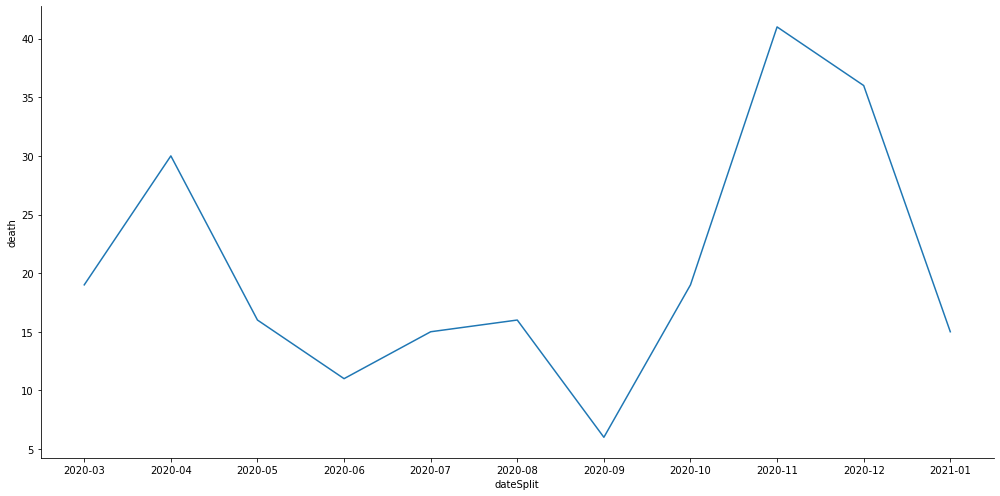

In [66]:
# Creating a new df from copying our original df
df_local = df.copy()

# Adding a dateSplit column to our new local_df based off the training dataest
df_local['dateSplit'] = X_train['cdc_case_earliest_dt'].dt.strftime('%Y-%m')

# Making a new df by grouping our dateSplit and adding death column
df_target = df_local[df_local['death_yn'] == 1].groupby('dateSplit', as_index=False).size().to_frame('death')

# Graphing the correlation between our continuous feature, "cdc_case_earliest_dt" and our target feature, "death_yn".
sn.relplot(x="dateSplit", y = 'death', data=df_target.reset_index(), height=7, aspect=2, kind='line')

In [67]:
# Observing the correlation between continuous feature and target feature using our training subset.

X_train.cdc_case_earliest_dt = pd.to_numeric(X_train.cdc_case_earliest_dt)
df_continuous = pd.concat([X_train['cdc_case_earliest_dt'], y_train], axis=1)
continuous_correlation = df_continuous[["cdc_case_earliest_dt", "death_yn"]].corr(method='pearson')
continuous_correlation

,cdc_case_earliest_dt,death_yn
cdc_case_earliest_dt,1.00000,-0.08482
death_yn,-0.08482,1.00000


#### 1.2.3 Interpretation of the results

- From observing our graph, it is hard to deduce that there is any clearly defined correlation between our continuous feature and the target feature.
- There is an obvious spike in data around March 2020 and November 2020. However, because our dataset only spans over the course of approximately a year, it is hard to come to any real conclusion from this.
- The initial spike in data falls roughly in line with the initial introduction of Covid-19 whereas the the second spike in data could be due to numerous external factors.
- As mentioned, our dataset is too small to make rational conclusion from this feature.
- Due to there being no trend of positivity between cdc_case_earliest_dt and death_yn, we will determine that this feature has a low correlation.

We will add our only continuous feature, "cdc_case_earliest_dt" to low correlation continuous features

In [68]:
low_correlation_continuous_features = ["cdc_case_earliest_dt"]

### 1.2.3 Plot interaction between categorical features and target feature

##### Cramer's V, a measure of association between two nominal variables. Based on Pearson’s Chi-Square statistic

In [69]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

In [70]:
trainingSubset = pd.concat([X_train, y_train], axis=1)
#creating a 8x8 matrix because we have 9 features, and I want to see the relationship between all of the features using the cramers function above
matrix = [[cramers_v(trainingSubset[column], trainingSubset[column2])for column2 in trainingSubset] for column in trainingSubset]

In [71]:
#selecting the columns of the merged training set 
trainingSubsetColumns = trainingSubset.columns

#making a panda dataframe of the matrix above
matrix_correlation = pd.DataFrame(matrix, columns=trainingSubsetColumns, index=trainingSubsetColumns)

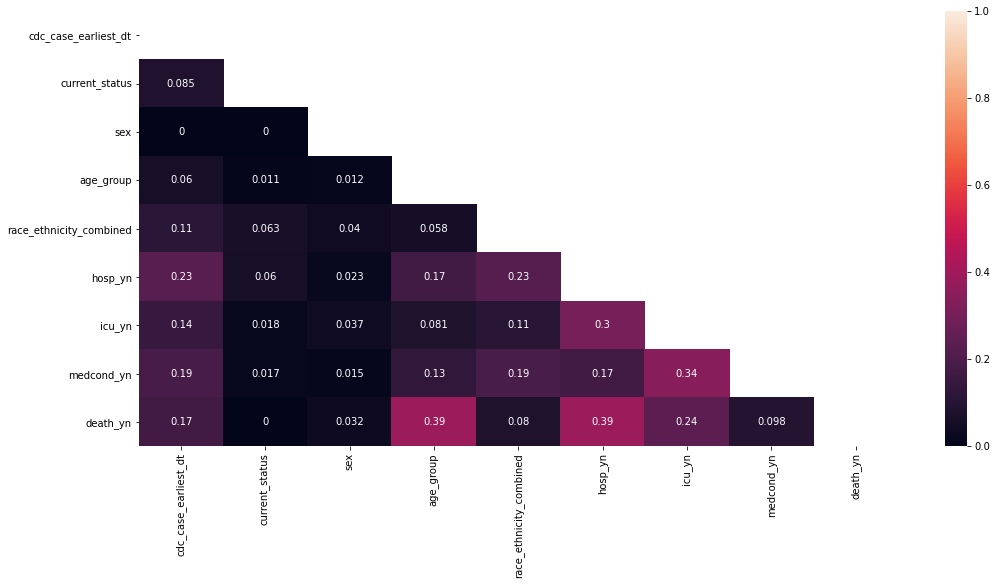

In [72]:
# Visualising of the correlation between the catergorical features vs categorical features. 

# We will now generate a mask for the upper triangle
mask = np.zeros_like(matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize = (17,8))
sn.heatmap(matrix_correlation, annot=True, mask=mask, vmax = 1)
plt.show()

##### Create stacked bar plots for categorical features


 current_status
Index 	 Count
Laboratory-confirmed case 	 6419
Probable Case 	 504

 sex
Index 	 Count
Female 	 3626
Male 	 3297

 age_group
Index 	 Count
20 - 29 Years 	 1310
10 - 19 Years 	 683
50 - 59 Years 	 1007
40 - 49 Years 	 1048
60 - 69 Years 	 782
80+ Years 	 311
30 - 39 Years 	 1055
0 - 9 Years 	 306
70 - 79 Years 	 421

 race_ethnicity_combined
Index 	 Count
White, Non-Hispanic 	 2368
Hispanic/Latino 	 670
Multiple/Other, Non-Hispanic 	 345
Unknown 	 2798
Asian, Non-Hispanic 	 185
Black, Non-Hispanic 	 494
American Indian/Alaska Native, Non-Hispanic 	 46
Native Hawaiian/Other Pacific Islander, Non-Hispanic 	 17

 hosp_yn
Index 	 Count
No 	 3652
Unknown 	 2814
Yes 	 455
OTH 	 2

 icu_yn
Index 	 Count
Unknown 	 6192
No 	 676
Yes 	 55

 medcond_yn
Index 	 Count
Unknown 	 5670
Yes 	 601
No 	 652


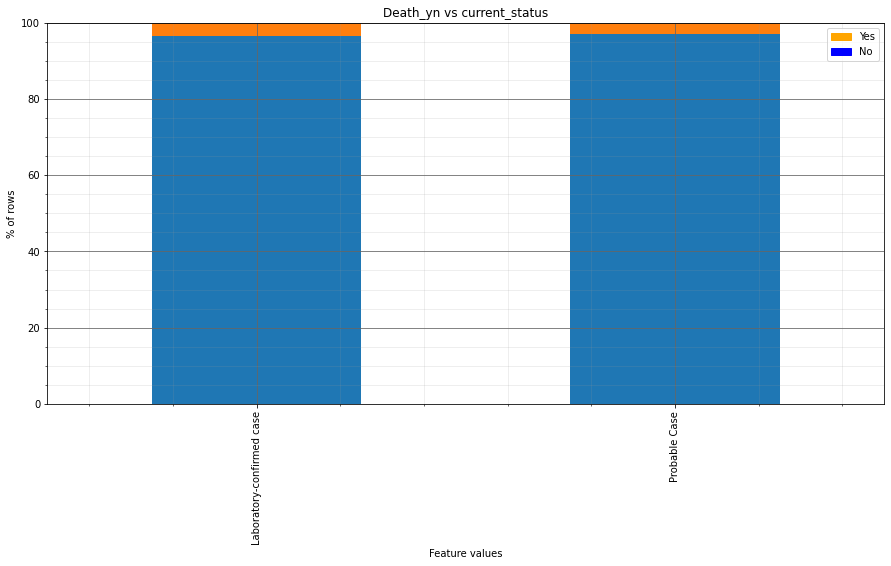

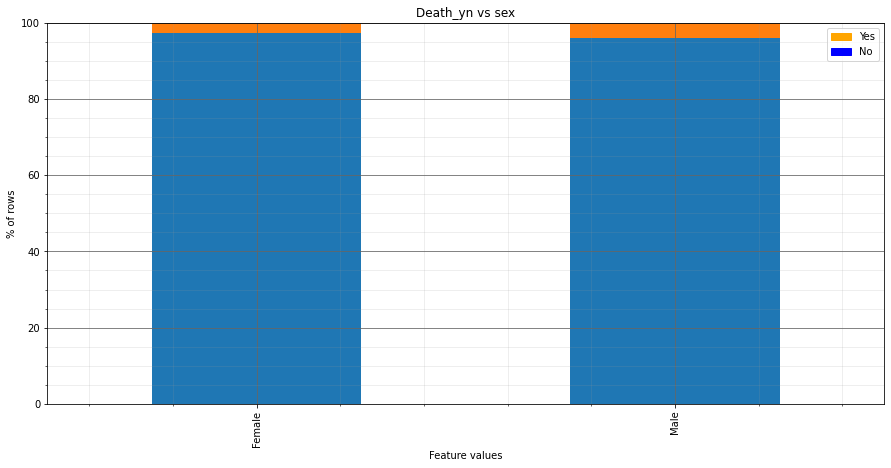

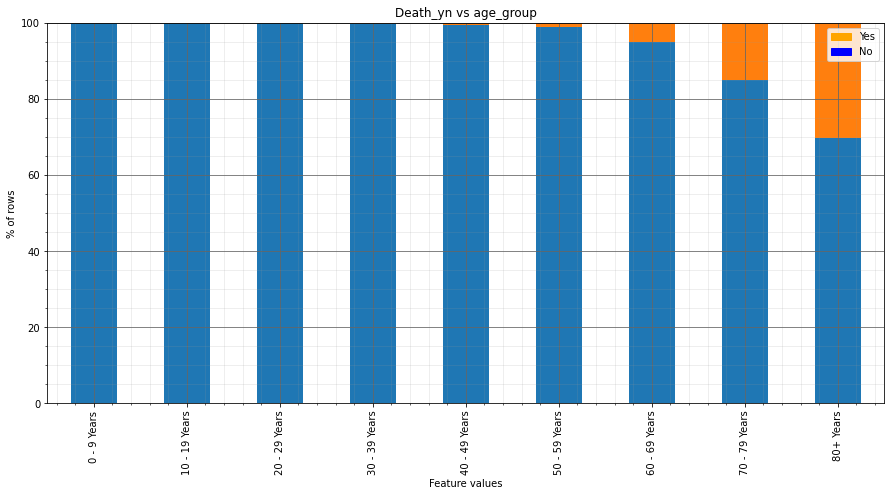

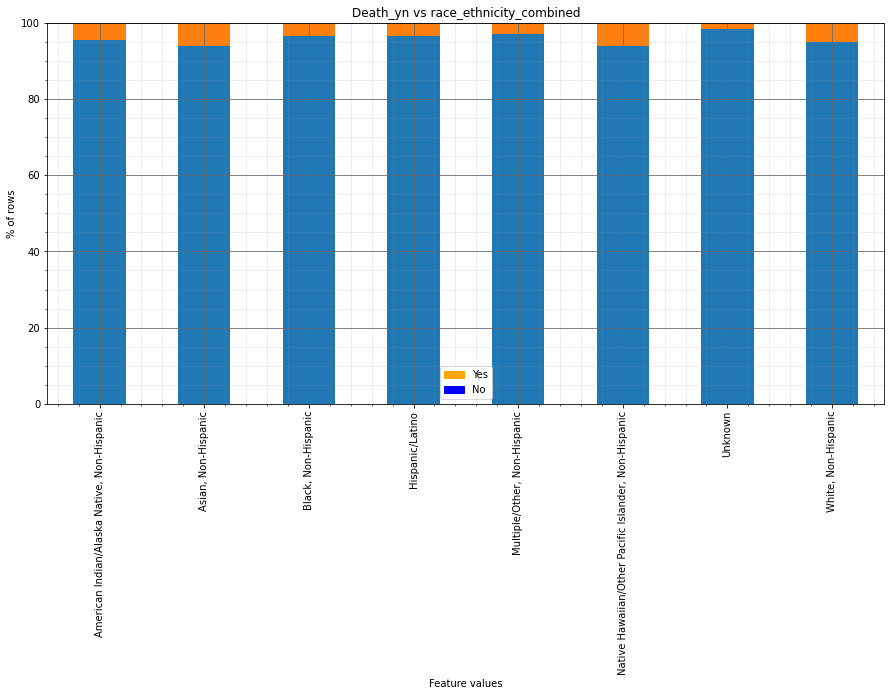

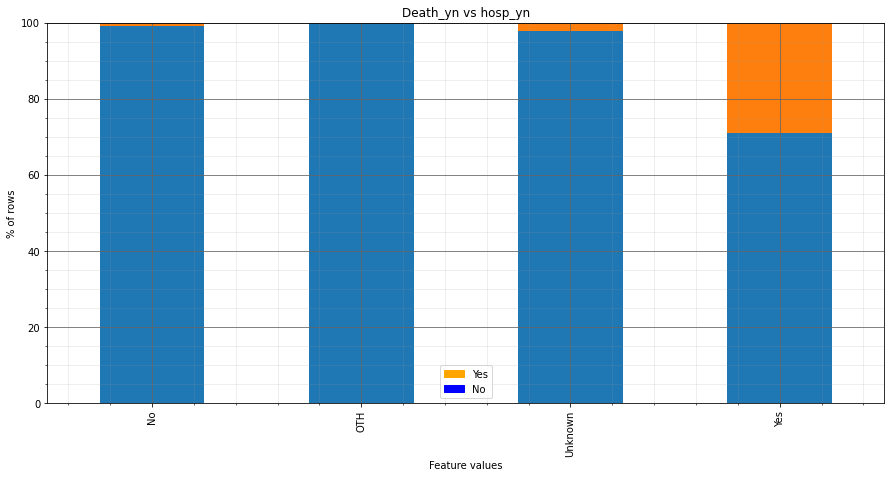

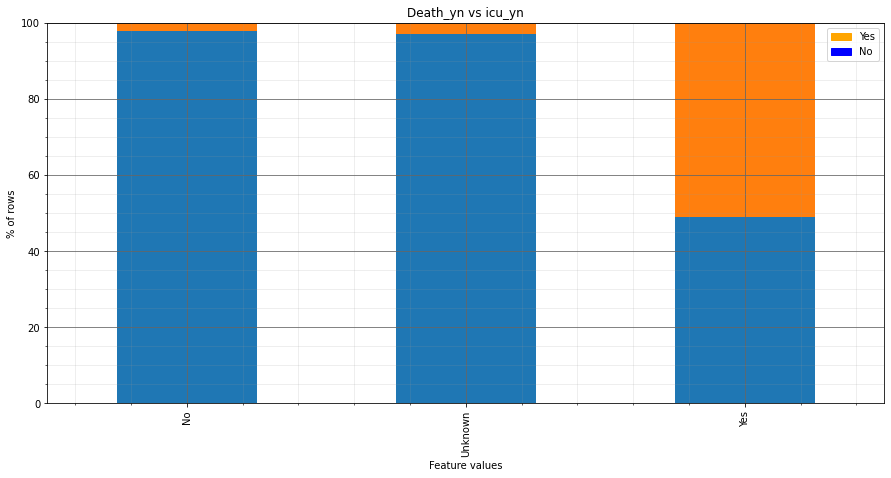

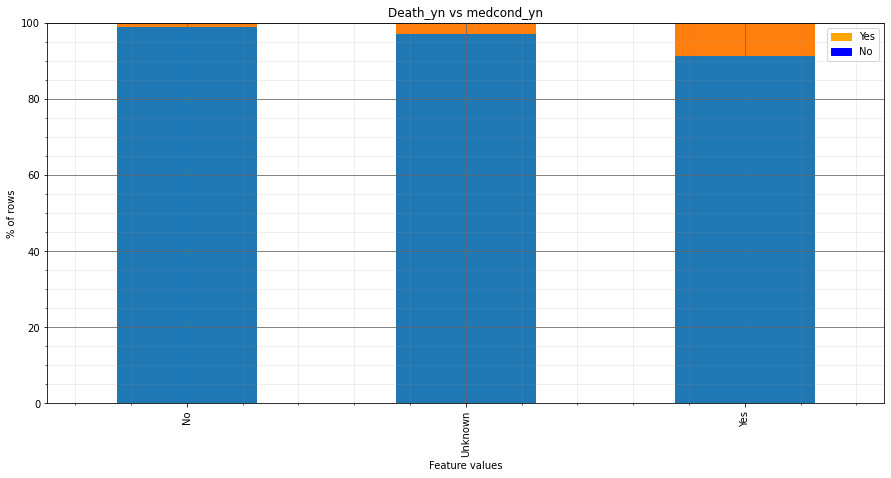

In [73]:
# for the comparison we will convert the target back to categorical
y_train = y_train.astype("category")
#X_train[categorical_columns].columns

# we will create temp dataframe for these plots, mergeing X_train and y_train
df_temp= pd.concat([X_train, y_train], axis=1)

for categorical_feature in categorical_columns:
    
    maxDelqEver = pd.unique(df_temp[categorical_feature].ravel())

    # add new column and set values to zero
    df_temp['percent'] = 0

    #print header
    print("\n", categorical_feature)
    print("Index \t Count")
    
    # for each delinquency category
    for i in maxDelqEver:

        count = df_temp[df_temp[categorical_feature] == i].count()['death_yn']
        count_percentage = (1 / count) * 100

        # print out index vs count
        print(i, "\t", count)

        index_list = df_temp[df_temp[categorical_feature] == i].index.tolist()
        for ind in index_list:
            df_temp.loc[ind, 'percent'] = count_percentage

    group = df_temp[['percent',categorical_feature,'death_yn']].groupby([categorical_feature,'death_yn']).sum()

    my_plot = group.unstack().plot(kind='bar', stacked=True, title=f"Death_yn vs {categorical_feature}", figsize=(15,7), grid=True)

    # add legend
    red_patch = mpatches.Patch(color='orange', label='Yes')
    blue_patch = mpatches.Patch(color='blue', label='No')
    my_plot.legend(handles=[red_patch, blue_patch], frameon = True)

    # add gridlines
    plt.grid(b=True, which='major', color='#666666', linestyle='-')
    plt.minorticks_on()
    plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)

    # add labels
    my_plot.set_xlabel("Feature values")
    my_plot.set_ylabel("% of rows")
    my_plot.set_ylim([0,100])
    
# drop 'percent' that was used only for stacked bar plot
df_temp = df_temp.drop("percent", 1)

#### Interpretation of the results

I will discuss each feature and how much value it may hold in predicting the target feature, death. This discussion will be based soley from my observation of the heatmap and stacked bar charts for each categorical feature.

##### Death vs Current Status
- From looking at the charts, we can see that current status has no real impact on our target feature, death.
- The figures for laboratory-confirmed case and probable case are relatively similar in percentage.
- The heatmap tells us that there is 0 correlation between current_status and death_yn which is the lowest of the categorical features.
- It is likely that this feature does not have any impact on death.

##### Death vs Sex
- Upon observing the charts, it once again appears that this feature, sex, has no impact on death.
- The results are eerily similar for both male and female, with male having a slightly higher death percentage (roughly 97% survival for woman and 96% survival for men in the barchart)
- These charts tells us that there is no real correlation between this feature and our target feature, death.

##### Death vs Age Group
- From observing the barcharts, it is clear there is definitive correlation between age group and death.
- This tells us that this feature has a high impact on our target feature.
- On the barchart, there is approximately 30% chance of death in age groups 80+ vs a below 1% chance in age groups 30-39 years old.
- The heatmap tells a similar story where it is tied the highest correlation feature alongside hosp_yn with a score of 0.39.

##### Death vs Race Ethnicity Combined

- From observing the charts, there is no real correlation between race & ethnicity in our target feature, death.
- The percentage of death is scattered and does not illustrate that one group in this feature is any more likely of death than another group.
- This feature does not hold value in predicting death.

##### Death vs Hospital 

- There is definitely a correlation between whether a patient attends hospital vs one who does not.
- This barchart reveals that patients have approximately 30% death while being hospitalised vs a less than 1% chance of death if they are not hospitalised.
- The heatmap also illustrates the correlation here as it has a tied highest correlation alongside age_group with a score of 0.39.
- This feature holds a lot of merit for predicting our target feature, death.

##### Death vs ICU
- From looking at the charts, it is clear that ICU heavily impacts the prediction of our target feature.
- Based on the barchart, patients in the ICU have approximately 50% chance of death vs approximately 2% chance of death of those who did not go to the ICU.
- This feature heavily impacts the prediction of our target feature.

##### Death vs Medical Condition
- Again, this feature is highly reflective of the outcome of our target feature.
- From the barchart, those with a medical condition have approximately a 8% chance of death vs those without a medical condition who have less than 2% chance of death.
- This feature holds value in predicting death.

Therefore, the subset of categorical features I find <b>promising</b> for predicting our target feature are:

- Age Group
- Hospital
- ICU
- Medical Condition

The features that I find do <b>not hold much merit</b> in predicting the target features are:
- Current Status
- Sex
- Race Ethnicity Combined


###### Listing the low correlation features

In [74]:
low_information_gain = ['current_status','sex','race_ethnicity_combined']

###### Listing the high correlation features

In [75]:
high_information_gain = ['age_group','hosp_yn','icu_yn', 'medcond_yn']

### 1.2.4 Summary & Drop Features

1. From Continuous vs Target plots (1.2.2) we identified the following to be dropped

In [76]:
low_correlation_continuous_features

['cdc_case_earliest_dt']

2. From Categorical vs Target (1.2.3) we identified the following to be dropped

In [77]:
low_information_gain

['current_status', 'sex', 'race_ethnicity_combined']

We will now drop these features
- Before dropping, we will duplicate the original dataframe, df and label it dfhighfeatuers. This will store the high correlation features for future use.
- We will also duplicate the original dataframe, df, and label it df_rev1
- We will drop features from this copy only (df_rev1)
- This will allow us to revert to the original dataset later if we decide to compare the performance of the reduced dataset (df_rev1) with the original dataset (df)
- However, cdc_case_earliest_dt will also be dropped from the original dataset (df) as we do not have enough dates to justify keeping this information. We would need data from 5+ years to make any kind of correlation between cdc_case_earliest_dt and death_yn.

In [78]:
# Before dropping, making a copy of original that contains the high correlation features
dfhighfeatuers = df.copy()
# Dropping all the low correlation features
dfhighfeatuers = dfhighfeatuers.drop(['current_status','sex','race_ethnicity_combined','cdc_case_earliest_dt'],1)

In [79]:
# drop all low correlation features
low_value_continuous_features = list(set(low_correlation_continuous_features))
low_value_categorical_features = list(set(low_information_gain))

# before dropping make copy of original
df_rev1 = df.copy()

# dropping cdc_case_earliest_dt from original df as this is not needed for our predictive modelling based on explanation above
df = df.drop(['cdc_case_earliest_dt'], 1)

# drop low value features
df_rev1.drop(low_value_continuous_features, 1, inplace=True)
df_rev1.drop(low_value_categorical_features, 1, inplace=True)

print('\nRemaining columns:', df_rev1.columns)
print('\nNew shape:', df_rev1.shape)


Remaining columns: Index(['age_group', 'hosp_yn', 'icu_yn', 'death_yn', 'medcond_yn'], dtype='object')

New shape: (9891, 5)


## 1.2.5 Prepare dataset for modeling
Now we have picked our descriptive features for the whole dataset, a number of additional steps will need to be taken to prepare the dataset for modeling 
- We will now convert the categorical variables into dummies variable to allow modeling
- We will then set up the train test split again based on the dataset with the dummies included

In [80]:
# set up dummies features
df_rev1 = pd.get_dummies(df_rev1, columns=['age_group', 'hosp_yn','icu_yn', 'death_yn','medcond_yn'], drop_first=True)
df_rev1.dtypes

age_group_10 - 19 Years    uint8
age_group_20 - 29 Years    uint8
age_group_30 - 39 Years    uint8
age_group_40 - 49 Years    uint8
age_group_50 - 59 Years    uint8
age_group_60 - 69 Years    uint8
age_group_70 - 79 Years    uint8
age_group_80+ Years        uint8
hosp_yn_OTH                uint8
hosp_yn_Unknown            uint8
hosp_yn_Yes                uint8
icu_yn_Unknown             uint8
icu_yn_Yes                 uint8
death_yn_1                 uint8
medcond_yn_Unknown         uint8
medcond_yn_Yes             uint8
dtype: object

#### Continuous columns are:

- There are no continuous columns remaining as 'cdc_case_earliest_dt' has been dropped

#### Categorical columns are:

In [81]:
categorical_columns = df_rev1.select_dtypes(include=['uint8']).columns.tolist()
categorical_columns

['age_group_10 - 19 Years',
 'age_group_20 - 29 Years',
 'age_group_30 - 39 Years',
 'age_group_40 - 49 Years',
 'age_group_50 - 59 Years',
 'age_group_60 - 69 Years',
 'age_group_70 - 79 Years',
 'age_group_80+ Years',
 'hosp_yn_OTH',
 'hosp_yn_Unknown',
 'hosp_yn_Yes',
 'icu_yn_Unknown',
 'icu_yn_Yes',
 'death_yn_1',
 'medcond_yn_Unknown',
 'medcond_yn_Yes']

#### Total features are:

In [82]:
features = categorical_columns
features

['age_group_10 - 19 Years',
 'age_group_20 - 29 Years',
 'age_group_30 - 39 Years',
 'age_group_40 - 49 Years',
 'age_group_50 - 59 Years',
 'age_group_60 - 69 Years',
 'age_group_70 - 79 Years',
 'age_group_80+ Years',
 'hosp_yn_OTH',
 'hosp_yn_Unknown',
 'hosp_yn_Yes',
 'icu_yn_Unknown',
 'icu_yn_Yes',
 'death_yn_1',
 'medcond_yn_Unknown',
 'medcond_yn_Yes']

### Setting up the train/test split
- This is based on the dataset with dummy values
- The target feature is stored in dataframe "y"
- The remaining features are stored in dataframe "X"
- Both are split into training and test subsets

In [83]:
# y is the target
y = df_rev1["death_yn_1"]
# X is everything else
X = df_rev1.drop(["death_yn_1"],1)
# Split the dataset into two datasets: 70% training and 30% test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1,  test_size=0.3)

print("The original range is: ",df_rev1.shape[0])
print("training range (70%):\t rows 0 to", round(X_train.shape[0]))
print("test range (30%): \t rows", round(X_train.shape[0]), "to", round(X_train.shape[0]) + X_test.shape[0])

The original range is:  9891
training range (70%):	 rows 0 to 6923
test range (30%): 	 rows 6923 to 9891


In [84]:
print("\nDescriptive features in X:\n", X_train.head(5))
print("\nTarget feature in y:\n", y_train.head(5))


Descriptive features in X:
       age_group_10 - 19 Years  age_group_20 - 29 Years  \
6597                        0                        1   
4876                        0                        1   
3775                        0                        1   
4995                        1                        0   
1817                        1                        0   

      age_group_30 - 39 Years  age_group_40 - 49 Years  \
6597                        0                        0   
4876                        0                        0   
3775                        0                        0   
4995                        0                        0   
1817                        0                        0   

      age_group_50 - 59 Years  age_group_60 - 69 Years  \
6597                        0                        0   
4876                        0                        0   
3775                        0                        0   
4995                        0            

#### Reset the indexes of the training and test splits
- We can see from the X_train printout below that the indexes are no longer consecutive
- This is the same for y_train, X_test, y_test
- This will need to be dealt with next as it will effect merging of dataframes in the coming sections

In [85]:
X_train.head(5)

,age_group_10 - 19 Years,age_group_20 - 29 Years,age_group_30 - 39 Years,age_group_40 - 49 Years,age_group_50 - 59 Years,age_group_60 - 69 Years,age_group_70 - 79 Years,age_group_80+ Years,hosp_yn_OTH,hosp_yn_Unknown,hosp_yn_Yes,icu_yn_Unknown,icu_yn_Yes,medcond_yn_Unknown,medcond_yn_Yes
6597,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0
4876,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0
3775,0,1,0,0,0,0,0,0,0,1,0,1,0,1,0
4995,1,0,0,0,0,0,0,0,0,1,0,1,0,1,0
1817,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0


In [86]:
# Need to reset the index to allow contatenation with predicted values otherwise not joining on same index...
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)
X_train.head(5)

,age_group_10 - 19 Years,age_group_20 - 29 Years,age_group_30 - 39 Years,age_group_40 - 49 Years,age_group_50 - 59 Years,age_group_60 - 69 Years,age_group_70 - 79 Years,age_group_80+ Years,hosp_yn_OTH,hosp_yn_Unknown,hosp_yn_Yes,icu_yn_Unknown,icu_yn_Yes,medcond_yn_Unknown,medcond_yn_Yes
0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0
1,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0
2,0,1,0,0,0,0,0,0,0,1,0,1,0,1,0
3,1,0,0,0,0,0,0,0,0,1,0,1,0,1,0
4,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0


We are now ready to model the datasets.

## 2. Predictive Modeling: Linear Regression

#### 2.1 Train a linear regression model using only the descriptive features selected from part 1 above

- In the cell below we will use features selected above to train a linear regression model. 
- For training, we will use only the train split from the train/test split performed above.

In [87]:
# Train aka fit, a model using all continuous and categorical features.
multiple_linreg = LinearRegression().fit(X_train, y_train)

#### 2.2 Print out the coefficients learned by the model

In [88]:
# Print the weights learned for each feature.
print("\nFeatures are: \n", X_train.columns)
print("\nCoeficients are: \n", multiple_linreg.coef_)
print("\nIntercept is: \n", multiple_linreg.intercept_)
print("\nFeatures and coeficients: \n", list(zip(X_train.columns, multiple_linreg.coef_)))


Features are: 
 Index(['age_group_10 - 19 Years', 'age_group_20 - 29 Years',
       'age_group_30 - 39 Years', 'age_group_40 - 49 Years',
       'age_group_50 - 59 Years', 'age_group_60 - 69 Years',
       'age_group_70 - 79 Years', 'age_group_80+ Years', 'hosp_yn_OTH',
       'hosp_yn_Unknown', 'hosp_yn_Yes', 'icu_yn_Unknown', 'icu_yn_Yes',
       'medcond_yn_Unknown', 'medcond_yn_Yes'],
      dtype='object')

Coeficients are: 
 [ 0.00113065  0.00133949 -0.00038946 -0.00236196 -0.00314893  0.02531091
  0.10287653  0.23745245 -0.0693107   0.00812723  0.19389625  0.04037971
  0.2704465  -0.0125425   0.00944255]

Intercept is: 
 -0.03175510540207646

Features and coeficients: 
 [('age_group_10 - 19 Years', 0.001130653340106506), ('age_group_20 - 29 Years', 0.00133948975002316), ('age_group_30 - 39 Years', -0.00038945538296718713), ('age_group_40 - 49 Years', -0.002361964246467602), ('age_group_50 - 59 Years', -0.0031489307835364556), ('age_group_60 - 69 Years', 0.025310905748253457), ('

#### 2.3 Interpreting the linear regression model

Before discussing coefficients learned by the model, we will firstly discuss linear regression.

Linear regression is a commonly used type of predictive analysis which is used to make predictions based on a linear relationship. It examines two things: 
- Does a set of predictor variables do a good job in predicting an outcome (dependent) variable
- Which variables in particular are significant predictors of the outcome variable, and in what way do they–indicated by the magnitude and sign of the beta estimates–impact the outcome variable

It finds the line of best fit that describes the relationship between the target and predictors.

To create the predictive model using linear regression, these coefficients must be "learned".
As seen in the image below, this is done using the least squares criterion. This means we find the line of best fit that describes the relationship between the target and predictors which minimises the sum of squared residuals (also known as sum of squared errors).

<img src="LinearRegression.png">
<b>Fig showing least squares criterion</b>


<b>Discussion of coefficients learned by the model</b>

- The regression coefficient tells us whether there is a positive or negative correlation between each independent variable the dependent variable. A positive coefficient indicates that as the value of the independent variable increases, the mean of the dependent variable also tends to increase. A negative coefficient suggests that as the independent variable increases, the dependent variable tends to decrease.
- From the values above can see the calculated intercept is -0.0318
    - This is the starting point. i.e. if all other coefficients were zero then the value for 'x' would be -0.0318.
- We can see all the coefficients for each features. These are zipped together in a single list for ease of inspection.The effect of these on the value 'x' is the same as for linear

<b>Benefits of Linear Regression</b>
- A benefit or advantage of using linear regression is that it has a considerable lower time complexity and lower computational power when compared to the other machine learning algorithms.
- Another benefit of linear regression is it's performance on linearly seperable datasets. Linear regression fits linearly seperable datasets almost perfectly and is often used to find the nature of the relationship between variables.

<b>Negatives of Linear Regression</b>
- A negative of linear regression is that it is prone to underfitting. Since linear regression assumes a linear relationship between the input and output varaibles, it fails to fit complex datasets properly.
- Another negative of linear regression is that it is sensitive to outliers. Outliers can significantly skew what values that fall within each threshold point.The outliers will have huge effects on valuess near the threshold



#### 2.4 Printing 100 predicted target features and evaluate the prediction
- Here we will print the predicted target feature value for the first 100 training examples. 
- We will threshold the predicted target feature value given by the linear regression model at 0.5, to get the predicted class for each example. 
    - If value is >= 0.5 it is cast to 1, if < 0.5 it is cast to 0

In [89]:
# calculate the prediction and threshold the value. If >= 0.5 its true
multiple_linreg_predictions_train = (multiple_linreg.predict(X_train) >= 0.5) * 1.0

print("\nPredictions with multiple linear regression: \n")
actual_vs_predicted_multiplelinreg = pd.concat([y_train, pd.DataFrame(multiple_linreg_predictions_train, columns=['Predicted'])], axis=1)
print(actual_vs_predicted_multiplelinreg.head(100))


Predictions with multiple linear regression: 

    death_yn_1  Predicted
0            0        0.0
1            0        0.0
2            0        0.0
3            0        0.0
4            0        0.0
..         ...        ...
95           0        0.0
96           0        0.0
97           0        0.0
98           0        0.0
99           0        0.0

[100 rows x 2 columns]


#### 2.5 Evaluation metrics based on training data
- We will print the classification evaluation measures computed on the training set (e.g. Accuracy, Confusion matrix, Precision, Recall, F1)
- We will discuss findings based on these measures

In [90]:
# Some more evaluation metrics.
print("==================== Train Data =======================")
print("Accuracy: ", metrics.accuracy_score(y_train, multiple_linreg_predictions_train))
print("Confusion matrix: \n", metrics.confusion_matrix(y_train, multiple_linreg_predictions_train))
print("Classification report:\n ", metrics.classification_report(y_train, multiple_linreg_predictions_train))
print("======================================================")

==================== Train Data =======================
Accuracy:  0.9685107612306804
Confusion matrix: 
 [[6690    9]
 [ 209   15]]
Classification report:
                precision    recall  f1-score   support

           0       0.97      1.00      0.98      6699
           1       0.62      0.07      0.12       224

    accuracy                           0.97      6923
   macro avg       0.80      0.53      0.55      6923
weighted avg       0.96      0.97      0.96      6923



##### Interpretation of results
- Accuracy
    - We have an accuracy of 97%. This is simply stating how often the model is correct. 
- Confusion Matrix
    - [0][0] TRUE NEGATIVE - The number that is predicted 0 that was actually 0
    - [0][1] FALSE POSITIVE - The number that is predicted 1 that is actually 0
    - [1][0] FALSE NEGATIVE - The number that is predicted 0 that is actually 1
    - [1][1] TRUE POSITIVE - The number that is predicted 1 that is actually 1
    
    - We can see <b>209 false negatives</b> from our confusion matrix. In real-world terms, this means we predicted 209 to live, where they actually died. This is quite high and is perhaps the most significant number of this confusion matrix.
    
    - In addition to this, the <b>misclassification rate</b> is approximately 3.15% ((False Positive + False Negative/ Total) *100) 
    - The prevalence (How often does the yes condition actually occur) is  3.24% ((Actual Yes/ Total) * 100)
- Precision - How good the model is at predicting the positive class
    - What % of the predicted positive are actually positive
    - It is the number values correctly predicted positive over the total number of  positive values
    - In other words, it is true positives/(true positives + false negatives).
    - Precision Positive is 0.62
    - Precision Negative is 0.97
- Recall
    - What % of the positive values did we predict
    - This relates to the the number of values which were correctly predicted positive over the total number of positive predictions that could have been made.
    - In other words, it is true positives/(true positives + false negatives).
    - Recall Positive is 0.07
    - Recall Negative is 1.00
- F1 Score
    - Is an a weighted average of Precision and recall
    - F1 Score Positive is 0.12
    - F1 Score Negative is 0.98

Summary
- Some of these results are reasonable.
- However, the positive recall and f1-score are very low. We can see the model is far better at predicting the negative class. 
- This makes sense as the model has more negative data to learn from as it is the majority class.
- This will help with predicting the chances of survival rates in patients. 
- The down side being that if we try to make an assessment on the liklihood of death being yes, the model will not make a great prediction based off of the low recall score.

#### 2.6 Evaluate the model using the hold-out (30% examples) test set
- The results from the test data will be compared the results from the training data.
- In addition they will be compared to the results from a cross-validated model (i.e. a new model trained and evaluated using cross-validation on the full dataset).

Printing Actual Death vs predicted based on test data

In [91]:
# calculate the prediction and threshold the value. If >= 0.5 its true
multiple_linreg_predictions_test = (multiple_linreg.predict(X_test) >= 0.5) * 1.0

print("\nPredictions with multiple linear regression: \n")
actual_vs_predicted_multiplelinreg = pd.concat([y_test, pd.DataFrame(multiple_linreg_predictions_test, columns=['Predicted'])], axis=1)
print(actual_vs_predicted_multiplelinreg.head(100))


Predictions with multiple linear regression: 

    death_yn_1  Predicted
0            0        0.0
1            0        0.0
2            0        0.0
3            0        0.0
4            0        0.0
..         ...        ...
95           0        0.0
96           0        0.0
97           0        0.0
98           0        0.0
99           0        0.0

[100 rows x 2 columns]


##### Evaluation metrics based on test data

In [92]:
# Some more evaluation metrics.
print("==================== Test Data =======================")
print("Accuracy: ", metrics.accuracy_score(y_test, multiple_linreg_predictions_test))
print("Confusion matrix: \n", metrics.confusion_matrix(y_test, multiple_linreg_predictions_test))
print("Classification report - Test data:\n ", metrics.classification_report(y_test, multiple_linreg_predictions_test))
print("\n==================== Train Data ======================")
print("Accuracy: ", metrics.accuracy_score(y_train, multiple_linreg_predictions_train))
print("Confusion matrix: \n", metrics.confusion_matrix(y_train, multiple_linreg_predictions_train))
print("\nClassification report: - Training data\n ", metrics.classification_report(y_train, multiple_linreg_predictions_train))

==================== Test Data =======================
Accuracy:  0.9659703504043127
Confusion matrix: 
 [[2863    5]
 [  96    4]]
Classification report - Test data:
                precision    recall  f1-score   support

           0       0.97      1.00      0.98      2868
           1       0.44      0.04      0.07       100

    accuracy                           0.97      2968
   macro avg       0.71      0.52      0.53      2968
weighted avg       0.95      0.97      0.95      2968


==================== Train Data ======================
Accuracy:  0.9685107612306804
Confusion matrix: 
 [[6690    9]
 [ 209   15]]

Classification report: - Training data
                precision    recall  f1-score   support

           0       0.97      1.00      0.98      6699
           1       0.62      0.07      0.12       224

    accuracy                           0.97      6923
   macro avg       0.80      0.53      0.55      6923
weighted avg       0.96      0.97      0.96      6923



**Interpretation of test results and comparison with training results**
- Accuracy
    - The accuracy of the test data is marginally lower 96.6% vs 96.9%. 
- Precision
    - The precision score for predicting the positive case has reduced drastically from 62% to 44%.
    - The precision score for predicting the negative case has remained the same at 97%.
- Recall
    - The recall score for predicting the positive case has decreased from 7% to 4%.
    - The recall score for predicting the negative case has remained the same at 100%.
- F1
    - The f1 score for predicting the positive case has decreased from 12% to 7%.
    - The f1 score for predicting the negative case has reamined the same at 98%.

**Summary**
- We are satisfied with these results as we are now testing the predictive model on data that has not been seen before.
- We can see marginal decreases in some scores, and drastic decreases in others (positive precision).
- These results are still ok and are a sign that the model is generalising.
- We will now explore this even further using cross validation.

#### 2.7 Cross validation
- We will now perform cross validation on the linear regression model. 
- Using cross validation we do repeated train/test splits and average the error on the test datasets. Therefore, it can result in a less biased result than a simple train/test split.
- To perform cross-validation we will randomly split the dataset into 10 equal partitions. 
- We will then use one partition as the test set and the union of all other partitions as the training set. 
- We then evaluate the results of the test set and then repeat these steps using a different partition as the test set for each iteration. 
- Finally, we will take the average of all results.
- During this validation, we will use 10-fold as increasing this number would increase computation time.
- We will store the results in a dictionary for later use


We will begin by creating a function to perform cross-validation as this is not provided by Scikit-Learn.
- Cross validation Function can be seen below

In [93]:
def cross_val_LinReg(X, y, cv=3, scoring='accuracy'):
    """Functions to carry out cross validation on the linear regression model
    Default number of validations is 3. The randon state will be updated 
    at each iteration to allow our results to be repeated"""
    
    # store results
    results = []
    # evaluate cv times and append to results
    for i in range(cv):
        # set up train test split
        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=i , test_size=0.3)
        # generate model
        multiple_linreg = LinearRegression().fit(X_train, y_train)
        # threshold
        multiple_linreg_predictions = (multiple_linreg.predict(X_test) >= 0.5) * 1.0
        # calc score
        if scoring=='accuracy':
            score = metrics.accuracy_score(y_test, multiple_linreg_predictions)
        elif scoring=='precision':
            score = metrics.precision_score(y_test, multiple_linreg_predictions)
        elif scoring=='f1':
            score = metrics.f1_score(y_test, multiple_linreg_predictions)
        elif scoring=='recall':
            score = metrics.recall_score(y_test, multiple_linreg_predictions)
        # append to results
        results.append(score)
    return results

- We will now create an additional function to perform 10 fold cross validation and store results into a dataframe
- This will be used to simplify further analysis the dataset, looking at accuracy, precision, recall, f1.

In [94]:
def cross_val_LinReg_DF(X,y):
    """Function to perform cross validation and store results 
    in dataframe. Cross validation looks at accuracy, precision, 
    recall, f1. Returns a dataframe with results"""

    linRegResults = {}
    # metrics to test against
    test_metrics = ['accuracy','precision','recall', 'f1']
    
    for metric in test_metrics:
        # generate test results
        result = cross_val_LinReg(X, y, cv=10, scoring=metric)
        length = len(result)
        # store result in dict
        linRegResults[metric] = sum(result)/length

    # create dataframe with results
    LinRegDF = pd.DataFrame.from_dict(linRegResults, orient='index', columns=['Linear_Regression'])
    
    return LinRegDF

Preform 10 fold cross validation using cross_val_LinReg_DF function
- Results summarised below

In [95]:
linRegDF = cross_val_LinReg_DF(X,y)
print(f"Mean results from 10 fold cross validation are:")
linRegDF

Mean results from 10 fold cross validation are:


,Linear_Regression
accuracy,0.966846
precision,0.450612
recall,0.042582
f1,0.077026


- These are the average of 10-fold cross-validations.

If we compare these to the the test results obtained above:
- Accuracy has remained relatively the same with the test results showing 96.6% while 10 fold cross validation shows 96.7%
- Precision has increased marginally by 1%, from 44% to 45%
- Recall has remained the same at 4%
- f1 score has increased slightly from 7% to 7.7%

These results are very similar to our test data result data obtained above. We are pleased with these results, Although the recall score is very low, it is identical to that of the test data so we can see that the model is generalising well.

## 3. Predictive Modeling: Logistic Regression

#### 3.1 Train a logistic regression model using only the descriptive features selected from part 1 above
We will now use the same feature set from above to perform logistic regression using only these features.

In [96]:
# Train aka fit, a model using all continuous and categorical features.
multiple_logisticreg = LogisticRegression().fit(X_train, y_train)

#### 3.2 Print out the coefficients learned by the model

In [97]:
# Print the weights learned for each feature.
print("\nFeatures are: \n", X_train.columns)
print("\nCoeficients are: \n", multiple_logisticreg.coef_[0])
print("\nIntercept is: \n", multiple_logisticreg.intercept_)
print("\nFeatures and coeficients: \n", list(zip(X_train.columns, multiple_logisticreg.coef_[0])))


Features are: 
 Index(['age_group_10 - 19 Years', 'age_group_20 - 29 Years',
       'age_group_30 - 39 Years', 'age_group_40 - 49 Years',
       'age_group_50 - 59 Years', 'age_group_60 - 69 Years',
       'age_group_70 - 79 Years', 'age_group_80+ Years', 'hosp_yn_OTH',
       'hosp_yn_Unknown', 'hosp_yn_Yes', 'icu_yn_Unknown', 'icu_yn_Yes',
       'medcond_yn_Unknown', 'medcond_yn_Yes'],
      dtype='object')

Coeficients are: 
 [-1.04604561 -1.05712821 -0.99004795 -0.50863459 -0.17212119  1.14050924
  2.10298886  3.01948162 -0.07881543  0.79416473  2.74681589  1.27490029
  1.98811877  0.09579056  0.79568424]

Intercept is: 
 [-6.5881802]

Features and coeficients: 
 [('age_group_10 - 19 Years', -1.046045612494519), ('age_group_20 - 29 Years', -1.0571282072938972), ('age_group_30 - 39 Years', -0.990047952940407), ('age_group_40 - 49 Years', -0.5086345859827749), ('age_group_50 - 59 Years', -0.17212118565469411), ('age_group_60 - 69 Years', 1.140509238549349), ('age_group_70 - 79 Year

#### 3.3 Interpreting the results 

Before we discuss the results of the coefficients above, we will firstly introduce logistic regression.

- Similar to linear regression, with logistic regression, we find the line of best fit.
- Logistic regression is the appropriate regression analysis to conduct when the dependent variable is dichotomous (binary). 
- However, we have seen above that the output of linear regression in a continious value and is not a probability. Instead, we manually thresholded the value in order to convert it into a binary classification.
- The probability is between 0 and 1.
We will briefly describe the the steps involved in the function:
    - The line of best fit is found.
    - The equation of the line is passed through a function called the sigmoid function.
    - The sigmoid function outputs a probability between 0 and 1.
    - The model then applies a threshold to the probability. By default, values < 0.5 are cast to 0 and values >= 0.5 are cast to 1.
    
The logistic regression function is a little different than the linear regression function. The model estimated in logistic regression is given by the logistic function: 

<br>
$probability(target=1|descriptive\_features)=logistic(w_0 + w_1 * feature_1 + w_2*feature_2 + ...+ w_n*feature_n)$ <br>
where $logistic(x)$ is defined as: $logistic(x) = \frac{e ^ x}{1 + e ^ x} = \frac{1}{1+e^{-x}}$



<b>Discussing the coefficients learned by the model</b>
- We can see above that the intercept is -6.588 (this is w_0 is the above formula). This is the value of y when x is zero. In other words it is where the model intercepts the x axis.
- If all other coefficients were zero, the model result would be -6.588.
- This is the input to the logistic function and the logistic function will then calculate the probability and threshold based on this.
- We can see the coefficients for each feature above. They are zipped together in a single list for ease of visualisation and interpretation.
- The value of each dummy is in relation to the reference value for that feature.
- The effect of each of these coefficients is the same as for linear regression.

<b>Benefits of Logistic Regression</b>
- We mentioned above that linear regression is sensitive to outliers. Logistic regression on the other hand is good at dealing with outliers.
- Logistic regression is less inclined to over-fitting but it can overfit in high dimensional datasets.

<b>Negatives of Logistic Regression</b>
- The major disadvantage of Logistic Regression is the assumption of linearity between the dependent variable and the independent variables.
- It can only be used to predict discrete functions. Hence, the dependent variable of Logistic Regression is bound to the discrete number set.

- The image below highlights our point about the minimal effect outliers can have on logistic regression model. 

<img src="LogisticRegression.png"> <br>


#### 3.4 Printing 100 predicted target features and evaluate the prediction
- Here we will print the predicted target feature value for the first 100 training examples based on training data

In [98]:
# calculate the prediction and threshold the value. If >= 0.5 its true
multiple_logisticreg_predictions_train = multiple_logisticreg.predict(X_train)

print("\nPredictions with multiple linear regression: \n")
actual_vs_predicted_multiplelogisticreg = pd.concat([y_train, pd.DataFrame(multiple_logisticreg_predictions_train, columns=['Predicted'])], axis=1)
print(actual_vs_predicted_multiplelogisticreg.head(100))


Predictions with multiple linear regression: 

    death_yn_1  Predicted
0            0          0
1            0          0
2            0          0
3            0          0
4            0          0
..         ...        ...
95           0          0
96           0          0
97           0          0
98           0          0
99           0          0

[100 rows x 2 columns]


#### 3.5 Evaluation metrics based on training data
- We will print the classification evaluation measures computed on the training set (e.g. Accuracy, Confusion matrix, Precision, Recall, F1)
- We will discuss finding based on these measures

In [99]:
# Some more evaluation metrics.
print("==================== Train Data =======================")
print("Accuracy: ", metrics.accuracy_score(y_train, multiple_logisticreg_predictions_train))
print("Confusion matrix: \n", metrics.confusion_matrix(y_train, multiple_logisticreg_predictions_train))
print("Classification report:\n ", metrics.classification_report(y_train, multiple_logisticreg_predictions_train))
print("======================================================")

==================== Train Data =======================
Accuracy:  0.970244113823487
Confusion matrix: 
 [[6657   42]
 [ 164   60]]
Classification report:
                precision    recall  f1-score   support

           0       0.98      0.99      0.98      6699
           1       0.59      0.27      0.37       224

    accuracy                           0.97      6923
   macro avg       0.78      0.63      0.68      6923
weighted avg       0.96      0.97      0.96      6923



Interpretation of results
- Accuracy
    - We have an accuracy of 97%
    
- Confusion Matrix
    - [0][0] TRUE NEGATIVE - The number predicted 0 that was actually 0
    - [0][1] FALSE POSITIVE - The number predicted 1 that is actually 0
    - [1][0] FALSE NEGATIVE - The number predicted 0 that is actually 1
    - [1][1] TRUE POSITIVE - The number predicted 1 that is actually 1
    - We can see 164 false negatives from our confusion matrix. In real-world terms, this means we predicted 164 to live, where they actually died. This is quite high and is perhaps the most significant number in this confusion matrix.
    - In addition to this, the misclassificaiton rate is approximately 1.5% ((False Positive + False Negative/Total) * 100)
    - The prevalence (How often does the yes condition actually occur) is  3.2% ((Actual Yes/ Total) * 100)
- Precision - How good model is a prediction the positive class
    - What % of the predicted positive are actually positive
    - It is the number values correctly predicted positive over the total number of  positive values
    - In other words, it is true positives/(true positives + false negatives).
    - Precision Positive is 0.59
    - Precision Negative is 0.98
- Recall - What % of the positive values did we predict
    - What % of the positive values did we predict
    - This relates to the the number of values which were correctly predicted positive over the total number of positive predictions that could have been made.
    - In other words, it is true positives/(true positives + false negatives).
    - Recall Positive is 0.27
    - Recall Negative is 0.99
- F1 Score - Is an a weighted average of Precision and recall
    - Is an a weighted average of Precision and recall
    - F1 Score Positive is 0.37
    - F1 Score Negative is 0.98


Summary
- All results are higher than those achieved for linear regression on the training set above.
- Recall and f1 scores are still slightly too low but this is understandable due to the imbalanced nature of our dataset. Despite this, it is still way better than linear's positive recall score of 0.07.
- The logistic model is also a little better at predicting the negative class.
- The down side being that if we try to make an assessment on the liklihood of death being yes, the model will not make a great prediction based off of the low recall score.


#### 3.6 Evaluate the model using the hold-out (30% examples) test set
- These results from the test data will be compared the results from the training data.
- In addition they will be compared to the results from a cross-validated model (i.e., a new model trained and evaluated using cross-validation on the full dataset).

Printing Actual Death_yn vs predicted based on test data

In [100]:
# calculate the prediction and threshold the value. If >= 0.5 its true
multiple_logisticreg_predictions_test = multiple_logisticreg.predict(X_test)

print("\nPredictions with multiple linear regression: \n")
actual_vs_predicted_multiplelogisticreg = pd.concat([y_test, pd.DataFrame(multiple_logisticreg_predictions_test, columns=['Predicted'])], axis=1)
print(actual_vs_predicted_multiplelogisticreg.head(20))


Predictions with multiple linear regression: 

    death_yn_1  Predicted
0            0          0
1            0          0
2            0          0
3            0          0
4            0          0
5            0          0
6            0          0
7            0          0
8            0          0
9            0          1
10           0          0
11           0          0
12           0          0
13           0          0
14           0          0
15           0          0
16           0          0
17           0          0
18           0          0
19           0          0


Evaluation based on test data

In [101]:
# Some more evaluation metrics.
print("==================== Test Data =======================")
print("Accuracy: ", metrics.accuracy_score(y_test, multiple_logisticreg_predictions_test))
print("Confusion matrix: \n", metrics.confusion_matrix(y_test, multiple_logisticreg_predictions_test))
print("Classification report:\n ", metrics.classification_report(y_test, multiple_logisticreg_predictions_test))
print("==================== Train Data =======================")
print("Accuracy: ", metrics.accuracy_score(y_train, multiple_logisticreg_predictions_train))
print("Confusion matrix: \n", metrics.confusion_matrix(y_train, multiple_logisticreg_predictions_train))
print("Classification report:\n ", metrics.classification_report(y_train, multiple_logisticreg_predictions_train))
print("======================================================")

==================== Test Data =======================
Accuracy:  0.9693396226415094
Confusion matrix: 
 [[2850   18]
 [  73   27]]
Classification report:
                precision    recall  f1-score   support

           0       0.98      0.99      0.98      2868
           1       0.60      0.27      0.37       100

    accuracy                           0.97      2968
   macro avg       0.79      0.63      0.68      2968
weighted avg       0.96      0.97      0.96      2968

==================== Train Data =======================
Accuracy:  0.970244113823487
Confusion matrix: 
 [[6657   42]
 [ 164   60]]
Classification report:
                precision    recall  f1-score   support

           0       0.98      0.99      0.98      6699
           1       0.59      0.27      0.37       224

    accuracy                           0.97      6923
   macro avg       0.78      0.63      0.68      6923
weighted avg       0.96      0.97      0.96      6923



Interpretation of test results and comparison with training results 
- Accuracy
    - The accuracy of the test data has decreased from 97% to 96.9%. 
- Precision
    - The precision score for predicting the positive case has increased from 59% to 60%.
    - The precision score for predicting the negative case has remained the same at 98%.
- Recall
    - The recall score for predicting the positive case has remained the same at 27%.
    - The recall score for predicting the negative case has remained the same at 99%.
- F1
    - The f1 score for predicting the positive case has remained the same at 37%.
    - The f1 score for predicting the negative case has remained the same at 98%.

Summary
- We are satisfied with these results as we are now testing the predictive model on data that has not been seen before.
- The majority of the values have remained the same and those that have changed have only done so by approximately 1%.
- These results are good and are a sign that the model is generalising.
- We will now investigate further with cross-validation.


#### 3.7 Cross validation
We will first create function to perform 10 fold cross validation and store results into dataframe
- This will be used to simplify further analysis the dataset, looking at accuracy, precision, recall, f1.

In [102]:
def cross_val_LogReg_DF(X,y):
    """Function to perform cross validation and store results 
    in dataframe. Cross validation looks at accuracy, precision, 
    recall, f1. Returns a dataframe with results"""

    logRegResults = {}
    # metrics to test against
    test_metrics = ['accuracy','precision','recall', 'f1']

    for metric in test_metrics:
        # generate test results
        result = cross_val_score(LogisticRegression(), X, y, scoring=metric, cv=10)
        # store result in dict
        logRegResults[metric] = result.mean()
        
    # create dataframe with results
    LogRegDF = pd.DataFrame.from_dict(logRegResults, orient='index', columns=['Logistic_Regression'])
    
    return LogRegDF

Preform 10 fold cross validation using cross_val_LogReg_DF function
- Results summarised below

In [103]:
logRegDF = cross_val_LogReg_DF(X,y)
print(f"Mean results from 10 fold cross validation are:")
logRegDF

Mean results from 10 fold cross validation are:


,Logistic_Regression
accuracy,0.969366
precision,0.581270
recall,0.247064
f1,0.340756


These results are in line with the previous results. We have taken the mean of 10 sets of results. 

## 4. Predictive Modeling: Random Forest

### 4.1 Train a random forest model using only the descriptive features selected from part 1 above 
- A random forest model will now be trained on our test data. 
- We use the RandomForestClassifier() function. 
- The random state will be set to 1 to allow the results to be repeated. This means that any ties between features will be split in the same way each time we run the code, thus giving us the same tree each time.

In [104]:
# Train RF with 100 trees
rfc = RandomForestClassifier(n_estimators=100, max_features='auto', oob_score=True, random_state=1)
rfc.fit(X_train, y_train)

RandomForestClassifier(oob_score=True, random_state=1)

### 4.2 Understanding the Random Forest model

- We will now interpret and discuss how the random forest model works. We will begin by explaining how random forests and decision trees work. We will then print examples of decision trees and then interpret the results.
- A random forest is an ensemble of decision trees and so we will begin our discussion by explaining a Decision Tree.

<b>Decision trees</b>
- A decision tree begins with a feature as a node at the top of the tree which splits or branches out into different outcomes. These splits are based on the information gain. By default, Scikit-Learn measures this information gain using the Gini impurity.
- Gini Impurity of a node is the probability that a randomly chosen sample in a node would be incorrectly labeled if it was labeled by the distribution of samples within the node.
- The feature with the lowest Gini impurity will sit at the root of each decision tree. The tree will then always split on the feature that gives the lowest Gini impurity. In other words, a decision tree tries to form nodes containing a high proportion of samples from a single class. It does this by finding values in the features that cleanly divide the data into classes.
- The splitting process is repeated until a stopping criteria is met (such as a maximum depth of the tree or the minimum number of samples in the leaf).
- The tree will always split on the feature that gives the highest information gain
- The feature with the highest information gain will sit at the root of each decision tree


<b>Random Forest</b>
- The random forest is made up of a number of decision trees
- Random forest uses two important concepts:
        - When training, each tree in a random forest learns from a random sample of the data points.
        - Only a subset of all the features are considered for splitting each node in each decision tree.
- The output of the random forest is then based on the majority output of all combined decision trees.
- The random forest will keep track of the importance of features in terms of the information gain described above.
 
We will now look at an example of a single decision tree to get a better understanding

####  4.2.1  Train Decision tree
We will train 2 decision trees, with the same test data 
- One with max_depth=4 and the other max_depth=10
- Max depth determines how deep a decision tree can go before it must give an answer

In [105]:
dtc4 = DecisionTreeClassifier(max_depth=4, random_state=1)
dtc10 = DecisionTreeClassifier(max_depth=10, random_state=1)
dtc4.fit(X_train, y_train)
dtc10.fit(X_train, y_train)
print("Max depth 4: \n",dtc4)
print("Max depth 10: \n",dtc10)

Max depth 4: 
 DecisionTreeClassifier(max_depth=4, random_state=1)
Max depth 10: 
 DecisionTreeClassifier(max_depth=10, random_state=1)


####  4.2.2  Display Decision tree
We will create graph of each tree and store as an image

In [106]:
# create a Graphviz png
with open("DecisionTree4.dot", 'w') as f1:
    f1 = export_graphviz(dtc4, out_file=f1, feature_names=X_train.columns)
with open("DecisionTree10.dot", 'w') as f2:
    f2 = export_graphviz(dtc10, out_file=f2, feature_names=X_train.columns)
!dot -Tpng DecisionTree4.dot -o DecisionTree4.png
!dot -Tpng DecisionTree10.dot -o DecisionTree10.png

We can see below the decision tree with max_depth=4
- We can see the root is hosp_yn at value <=0.5 - This splits the data best i.e. has the highest information gain
- For each split the the model selects the next best feature
- This continues until it reaches a leaf node where the data cannot be split anymore
- The output of this is the prediction
- We can see one path below is resolved in 4 branches
    - hosp_yn <= 0.5 -> age_group_80+ Years <= 0.5 -> age_group_70-79 Years <= 0.5 -> age_group_60-69 Years <= 0.5 -> Resolved to TRUE
    - Note: only 1 entry meets this requirement.
    - All other entries need additional branches to be resolved

<img src="DecisionTree4.png">

Viewing a decision tree with maxdepth=10 shows how complicated this model becomes 
- This is only one example of a decision tree. 
- A Random forests has 100 decision trees by default
- Each decision tree is given a slightly different view of the data

<img src="DecisionTree10.png">

#### 4.2.3 Interpretation of the random forest model

For simplicity, we will only discuss the decision tree above with max_depth=4:
- We can see that the root node is hosp_yn with a gini impurity of 0.063. The Samples is equal to 6923 meaning that there are 6923 observations in this node. The value shows the number of samples in each class. We can see that there are 6699 in class 0 and 224 in class 1.

- This feature splits the data best and has the highest information gain. We can see that one path is resolved from this one split alone. In this dataset, this feature is the strongest predictor of the outcome.

- This is only one example of a decision tree. The random forest we have trained will be a combination of 100 decision trees.
- As mentioned above, the random forest keeps track of the importance of features.
- The list of importances are shown below.
- The more important features are the features that the random forest has identified as having higher information gain.
- The list is the combined result of the 100 decision trees which were used to train the random forest classifier.
- This list will give us an idea of which features are the most important to keep as we move forward with our modelling.

In [107]:
importance = pd.DataFrame({'feature': X_train.columns, 'importance':rfc.feature_importances_})
importance.sort_values('importance', ascending=False)

,feature,importance
10,hosp_yn_Yes,0.338207
7,age_group_80+ Years,0.235084
12,icu_yn_Yes,0.098383
11,icu_yn_Unknown,0.072026
6,age_group_70 - 79 Years,0.066823
14,medcond_yn_Yes,0.035662
13,medcond_yn_Unknown,0.032589
9,hosp_yn_Unknown,0.026553
3,age_group_40 - 49 Years,0.025386
4,age_group_50 - 59 Years,0.022784


We can see from the list above that many of the features provide little to no information gain. It is interesting to note that the categorical features are the worst preforming features 

### 4.4 Printing 100 predicted target features and evaluate the prediction 
- Here we will print the predicted target feature value for the first 100 training examples. 

In [108]:
# Predicted class labels for all examples, 
# using the trained model, on in-sample data (same sample used for training and test)
rfc_predictions_train = rfc.predict(X_train)
df_true_vs_rfc_predicted = pd.DataFrame({'ActualClass': y_train, 'PredictedClass': rfc_predictions_train})
df_true_vs_rfc_predicted.head(100)

,ActualClass,PredictedClass
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
95,0,0
96,0,0
97,0,0
98,0,0


### 4.5 Evaluation metrics based on training data
- We will print the classification evaluation measures computed on the training set (e.g. Accuracy, Confusion matrix, Precision, Recall, F1)
- We will discuss finding based on these measures

In [109]:
print("==================== Train Data =======================")
print("Accuracy: ", metrics.accuracy_score(y_train, rfc_predictions_train))
print("Confusion matrix: \n", metrics.confusion_matrix(y_train, rfc_predictions_train))
print("Classification report:\n ", metrics.classification_report(y_train, rfc_predictions_train))

==================== Train Data =======================
Accuracy:  0.9716885743174924
Confusion matrix: 
 [[6677   22]
 [ 174   50]]
Classification report:
                precision    recall  f1-score   support

           0       0.97      1.00      0.99      6699
           1       0.69      0.22      0.34       224

    accuracy                           0.97      6923
   macro avg       0.83      0.61      0.66      6923
weighted avg       0.97      0.97      0.96      6923



<b>Interpretation of results</b>

- Accuracy
    - We have an accuracy of 97%
    
- Confusion Matrix
    - [0][0] TRUE NEGATIVE - The number predicted 0 that was actually 0
    - [0][1] FALSE POSITIVE - The number predicted 1 that is actually 0
    - [1][0] FALSE NEGATIVE - The number predicted 0 that is actually 1
    - [1][1] TRUE POSITIVE - The number predicted 1 that is actually 1
    - We can see <b>174 false negatives</b> from our confusion matrix. In real-world terms, this means we predicted 174 to live, where they actually died. This is quite high and is perhaps the most significant number in this confusion matrix.
    - In addition to this, the misclassificaiton rate is approximately 2.8% ((False Positive + False Negative/Total) * 100)
    - The prevalence (How often does the yes condition actually occur) is  3.2% ((Actual Yes/ Total) * 100)
- Precision - How good model is a prediction the positive class
    - What % of the predicted positive are actually positive
    - It is the number values correctly predicted positive over the total number of  positive values
    - In other words, it is true positives/(true positives + false negatives).
    - Precision Positive is 0.69
    - Precision Negative is 0.97
- Recall - What % of the positive values did we predict
    - What % of the positive values did we predict
    - This relates to the the number of values which were correctly predicted positive over the total number of positive predictions that could have been made.
    - In other words, it is true positives/(true positives + false negatives).
    - Recall Positive is 0.22
    - Recall Negative is 1.00
- F1 Score - Is an a weighted average of Precision and recall
    - Is an a weighted average of Precision and recall
    - F1 Score Positive is 0.34
    - F1 Score Negative is 0.99

Summary
- Given the results we achieved for linear and logistic regression, these results show a large improvement in nearly all scores.
- Recall and f1 scores are still slightly too low but this is understandable due to the imbalanced nature of our dataset. Despite this, it is still way better than linear's positive recall score of 0.07.
- However, we must evaluate these results on test data in order to see how the model is generalising. Given how high these scores are, there is a risk that the model is overfitting which occurs when a model trains very well but does not generalise well to a new dataset.


### 4.6 Evaluate the model using the hold-out (30% examples) test set
- These results from the test data will be compared the results from the training data.
- In addition they will be compared to the results from a cross-validated model (i.e., a new model trained and evaluated using cross-validation on the full dataset).

Printing Actual death_yn vs predicted based on test data

In [110]:
# Predicted class labels for all examples, 
# using the trained model, on in-sample data (same sample used for training and test)
rfc_predictions_test = rfc.predict(X_test)
df_true_vs_rfc_predicted_test = pd.DataFrame({'ActualClass': y_test, 'PredictedClass': rfc_predictions_test})
df_true_vs_rfc_predicted_test.head(20)

,ActualClass,PredictedClass
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
5,0,0
6,0,0
7,0,0
8,0,0
9,0,1


Evaluation metrics based on test data

In [111]:
print("==================== Test Data =======================")
print("Accuracy: ", metrics.accuracy_score(y_test, rfc_predictions_test))
print("Confusion matrix: \n", metrics.confusion_matrix(y_test, rfc_predictions_test))
print("Classification report:\n ", metrics.classification_report(y_test, rfc_predictions_test))
print("==================== Train Data =======================")
print("Accuracy: ", metrics.accuracy_score(y_train, rfc_predictions_train))
print("Confusion matrix: \n", metrics.confusion_matrix(y_train, rfc_predictions_train))
print("Classification report:\n ", metrics.classification_report(y_train, rfc_predictions_train))
print("======================================================")

==================== Test Data =======================
Accuracy:  0.9639487870619946
Confusion matrix: 
 [[2847   21]
 [  86   14]]
Classification report:
                precision    recall  f1-score   support

           0       0.97      0.99      0.98      2868
           1       0.40      0.14      0.21       100

    accuracy                           0.96      2968
   macro avg       0.69      0.57      0.59      2968
weighted avg       0.95      0.96      0.96      2968

==================== Train Data =======================
Accuracy:  0.9716885743174924
Confusion matrix: 
 [[6677   22]
 [ 174   50]]
Classification report:
                precision    recall  f1-score   support

           0       0.97      1.00      0.99      6699
           1       0.69      0.22      0.34       224

    accuracy                           0.97      6923
   macro avg       0.83      0.61      0.66      6923
weighted avg       0.97      0.97      0.96      6923



Interpretation of test results and comparison with training results 
- The accuracy for the test is much lower as we are not testing the model with data it has not see before
- The scores seem reasonable and are in line with the other models test results

Interpretation of test results and comparison with training results 
- Accuracy
    - The accuracy of the test data has decreased from 97% to 96.4%. 
- Precision
    - The precision score for predicting the positive case decreased from 69% to 40%.
    - The precision score for predicting the negative case has remained the same at 97%.
- Recall
    - The recall score for predicting the positive case has decreased from 22% to 14%.
    - The recall score for predicting the negative case has decreased from 100% to 99%.
- F1
    - The f1 score for predicting the positive case has decreased from 34% to 21%.
    - The f1 score for predicting the negative case has decreased from 99% to 98%.

Summary
- The accuracy for the test data is still high at 96.4%. However, most other scores have dropped considerably in comparison to the training data, in particular recall positive and f1 positive.
- The results of test data are still reasonable considering that we are testing on data the model has not seen before. Most of the scores are in line or better than what we seen on test data for linear and logistic regression.
- However, we were hoping for slightly higher scores given how high the training scores were. We will now perform cross-validation in order to further test the random forest model.

### 4.7 Cross validation
- We will preform cross validation and store the results in a dictionary for later use

In [112]:
def cross_val_RandomForest_DF(X,y, depth=None, estimators=100):
    """Function to perform cross validation and store results 
    in dataframe. Cross validation looks at accuracy, precision, 
    recall, f1. Returns a dataframe with results"""

    # store results in dict
    RandomForestResults = {}
    # metrics to test against
    test_metrics = ['accuracy','precision','recall', 'f1']

    for metric in test_metrics:
        # generate test results
        result = cross_val_score(RandomForestClassifier(n_estimators=estimators, max_features='auto', oob_score=True, random_state=1, max_depth=depth), X, y, scoring=metric, cv=10)
        # store result in dict
        RandomForestResults[metric] = result.mean()
    
    # create dataframe with results
    RandomForestDF = pd.DataFrame.from_dict(RandomForestResults, orient='index', columns=['Random_Forests'])

    return RandomForestDF

##### The results for Random Forests are summarized below

In [113]:
RandomForestDF = cross_val_RandomForest_DF(X,y)
print(f"Mean results from 10 fold cross validation are:")
RandomForestDF

Mean results from 10 fold cross validation are:


,Random_Forests
accuracy,0.968658
precision,0.552775
recall,0.262121
f1,0.349161


The results above are inline with expectation
- The accuracy is approximately the same at 96.9%
- The precision has slightly decreased, from 69% to 55%.
- The positive recall has increased from 22% to 26%
- The f1 score is approximately the same

### 4.8 Out of bag accuracy
- This is the out of bag error estimate 
- It is an internal error estimate of a random forest as it is being constructed.
- It is used as an additional measure and should be line with the cross validation results
- This is generally expected to be the lowest

In [114]:
# compute the out-of-bag classification accuracy
rfc.oob_score_

0.9674996388848764

This value is in line with the Cross validation results above. This is good news for our model.

## 5. Improving Predictive Models

### 5.1 Which model of the ones trained above performs better at predicting the target feature? 

- In the cell below we will display a summary of the cross-validation results of all three models. We will then discuss the findings below the output of the concatenation.
- A reminder that the results here are for predicting the positive class (binary_outcome = 1)

In [115]:
ResultsDF = pd.concat([linRegDF, logRegDF, RandomForestDF], axis=1)
ResultsDF

,Linear_Regression,Logistic_Regression,Random_Forests
accuracy,0.966846,0.969366,0.968658
precision,0.450612,0.581270,0.552775
recall,0.042582,0.247064,0.262121
f1,0.077026,0.340756,0.349161


- There is quite a bit of variation in the values, especially between the recall and f1 scores.
- Each of the models have a 96+% level of accuracy.
- For precision, Logistic and Random Forest are performing the best with 58% and 55% respectively.
- For recall, Logistic and Random Forest are performing the best again, with 24.7% and 26.2% respectively.
- For the f1 scores, again, Logistic and Random Forest are performing the best with 34% and 34.9% respectively

In conclusion, we determined that the best performing model out of those we have trained is <b>Random Forest</b>.
Although it does not have as high a precision score as Logistic Regression, it has the highest recall and f1 and therefore is performing the best at predicting class 1.
Logistic Regression is the second best model.
Although linear regression has a high accuracy, the recall and f1 scores are lower than the other two models, telling us that it is not as good at predicting class 1.

### Is the model more accurate than a simple model that always predicts the majority class
- We will compare our results above to a simple model which predicts for the majority class
- First we will get the breakdown of the test dataset and see which is the majority class

In [116]:
good_count = y_test[y_test == 1].count()
bad_count = y_test[y_test == 0].count()
total = good_count+ bad_count
print(f'From original dataset: \t\tCount {total}')
print(f'Total number of deaths:\t {good_count}\t{round(good_count/len(y_test)*100,2)}%')
print(f'Total number of no deaths:\t {bad_count}\t{round(bad_count/len(y_test)*100,2)}%')

From original dataset: 		Count 2968
Total number of deaths:	 100	3.37%
Total number of no deaths:	 2868	96.63%


- We can see the majority class is 0 or death_yn=No 
- We will now generate scores for predicting the majority class

In [117]:
# generate array of 2968 zeros (length of test dataset)
majority = np.zeros(2968)
# create dataframe 
df_majorityClass = pd.DataFrame(majority, columns=['prediction'])
# calculate scores of simple predictin vs actual
print("Accuracy: ", metrics.accuracy_score(y_test, df_majorityClass))
print("Confusion matrix: \n", metrics.confusion_matrix(y_test, df_majorityClass))
print("Classification report:\n ", metrics.classification_report(y_test, df_majorityClass))

Accuracy:  0.9663072776280324
Confusion matrix: 
 [[2868    0]
 [ 100    0]]
Classification report:
                precision    recall  f1-score   support

           0       0.97      1.00      0.98      2868
           1       0.00      0.00      0.00       100

    accuracy                           0.97      2968
   macro avg       0.48      0.50      0.49      2968
weighted avg       0.93      0.97      0.95      2968



- We can see that our majority class is class 0. When we create a simple model which always predicts the majority, the accuracy is 96.63%
- Our precision is 97% and as expected, recall is 100% as we have predicted class 0 every time. f1 is 98% as expected, as this is the weighted average of precision and recall. 
- We have a high accuracy and precision due to the fact that our data is so heavily skewed towards a negative outcome, it creates a lot of false positives.
- Despite this, if we compare our scores against our three models for class 0, we can see that all of our model's accuracy still performs better that this model which always predicts the majority.

 - Our results obtained were as followed:
 
 
Linear regression:
- Accuracy 96.7%

Logistic regression:
- Accuracy 97%

Random Forests:
- Accuracy 96.9%


### 5.2 Summarise your understanding of the problem and of your predictive modeling results so far
#### 5.2.1 Summary

My understanding of this homework is that we are working towards finding a model which best predicts the binary outcome of our target feature, death in an individual with Covid-19. An outcome of 1 indicates that the individual dies, an outcome of 0 means the individual has lived. Based on this understanding, it is more important for our model to be able to predict the positive class (class 1) than the negative class. 

A critical point of note from our dataset is that it is heavily imbalanced. There is a much lower representation of class 1 than class 0. This makes it more difficult for us to predict death being "Yes". This has been reflected in our extremely low recall positive scores for each of our models. The feature that is most important for us to correctly to predict is also the feature with the last amount of data for us to model, which creates problems for us.

We will now discuss each of the metrics we used to evaluate our models off of:

<b>Accuracy:</b> This metric is straight forward in that it tells us how often the model is correct. It focusses on both the positive and negative class and so is more suited to a more balanced dataset. We will monitor and observe this metric but it will not be our focus.

<b>Precision:</b> This metric illustrates the number of values which were correctly predicted positive over the total number of positive values predicted. This means that the precision takes into account the positive predicitons made that should have been negative. Again, we will monitor this metric but it will not be our main focus.

<b>Recall:</b> This metric tells us the number of values which were correctly predicted positive over the total number of positive predictions that could have been made. It takes into account the negative predictions made that should have been positive. This means that this metric is extremely important to us in predicting if an individual who is going to survive. So far, our recall scores for each of our models has not been outstanding due to our models being trained with much more class 0 data. As we proceed with this question, we will be looking to increase our recall scores specifically.

<b>f1:</b> This score is a weighted average of precision and recall. As we are looking to try increase our recall score while maintaining our precision scores, we will monitor this score throughout to ensure it does not drop significantly.


If this was part of a larger project that includes a team of people, it would be important to have a discussion with the domain expert to ensure we are prioritising the correct metric in our analysis. Without the ability to have this discussion, we will assume that recall is the most important for us to improve our model and we will also ensure that f1 scores do not decrease in order to maintain a balance between precision and recall. We are confident that by focusing on these metrics, we can improve the ability of the models to predict death in an individual with Covid-19.


#### 5.2.2 New Ideas to improve the best model

##### All features
- We will now repeat the tests using all features 
- First we set up the dataframe using the original features

In [118]:
# dataframe with all features = original dataframe
df_all = pd.get_dummies(df)
# set X,y
y = df_all["death_yn"]
X = df_all.drop(["death_yn"],1)
print("number of features incl dummies: ", len(X.columns))

number of features incl dummies:  31


With the dataframe now setup we will generate new set of results based on all the features
- This operation is simplified as we have set up functions in part 2,3,4 to allow cross validated scores to be returned in dataframes 

In [119]:
df_all.dtypes

death_yn                                                                        int64
current_status_Laboratory-confirmed case                                        uint8
current_status_Probable Case                                                    uint8
sex_Female                                                                      uint8
sex_Male                                                                        uint8
age_group_0 - 9 Years                                                           uint8
age_group_10 - 19 Years                                                         uint8
age_group_20 - 29 Years                                                         uint8
age_group_30 - 39 Years                                                         uint8
age_group_40 - 49 Years                                                         uint8
age_group_50 - 59 Years                                                         uint8
age_group_60 - 69 Years                               

In [120]:
# calculate Linear regression, logistic regression, random forest results again using all features
linRegDF = cross_val_LinReg_DF(X,y)
logRegDF = cross_val_LogReg_DF(X,y)
RandomForestDF = cross_val_RandomForest_DF(X,y)
# merge all 3 models into dataframe
ResultsDF_allFeatures = pd.concat([linRegDF, logRegDF, RandomForestDF], axis=1)
ResultsDF_allFeatures

,Linear_Regression,Logistic_Regression,Random_Forests
accuracy,0.966947,0.967849,0.966737
precision,0.483945,0.525733,0.495335
recall,0.044780,0.258807,0.283428
f1,0.081062,0.342245,0.358536


#### High correlation features only
- We will now repeat the tests using the high correlation features identified in part (1.2.3)
- Again we set up the dataframe but now we use the list of high_correlation_features only

In [121]:
df_highcorr = pd.get_dummies(dfhighfeatuers)
y = df_highcorr["death_yn"]
X = df_highcorr.drop(["death_yn"],1)
# X = dfhighcorr[high_correlation_features]
print("Number of features: ", len(X.columns))

Number of features:  19


In [122]:
# calculate Linear regression, logistic regression, random forest results again
linRegDF = cross_val_LinReg_DF(X,y)
logRegDF = cross_val_LogReg_DF(X,y)
RandomForestDF = cross_val_RandomForest_DF(X,y)
# merge all 3 models into dataframe
ResultsDF_HighCorrFeatures = pd.concat([linRegDF, logRegDF, RandomForestDF], axis=1)
ResultsDF_HighCorrFeatures

,Linear_Regression,Logistic_Regression,Random_Forests
accuracy,0.966846,0.969568,0.968658
precision,0.450612,0.585394,0.552775
recall,0.042582,0.256155,0.262121
f1,0.077026,0.349773,0.349161


### Comparison of feature set so far

In [123]:
print("\nScores using all features: 31 features (0 features dropped)")
print("===================================================================")
print(ResultsDF_allFeatures)
print("\nScores using subset of features: 16 features (15 features dropped - from part 1)")
print("===================================================================")
print(ResultsDF)
print("\nScores using high Correlation features only: 19 features (12 features dropped)")
print("===================================================================")
print(ResultsDF_HighCorrFeatures)


Scores using all features: 31 features (0 features dropped)
           Linear_Regression  Logistic_Regression  Random_Forests
accuracy            0.966947             0.967849        0.966737
precision           0.483945             0.525733        0.495335
recall              0.044780             0.258807        0.283428
f1                  0.081062             0.342245        0.358536

Scores using subset of features: 16 features (15 features dropped - from part 1)
           Linear_Regression  Logistic_Regression  Random_Forests
accuracy            0.966846             0.969366        0.968658
precision           0.450612             0.581270        0.552775
recall              0.042582             0.247064        0.262121
f1                  0.077026             0.340756        0.349161

Scores using high Correlation features only: 19 features (12 features dropped)
           Linear_Regression  Logistic_Regression  Random_Forests
accuracy            0.966846             0.969568  

- <b>Linear Regression:</b> From the results, we can see accuracy has remained approximately the same. Precision, recall and f1 have all decreased.
- <b>Logistic Regression:</b> We can see that accuracy has slightly increased, as has precision. Recall and f1 have decreased ever so slightly however. 
- <b>Random Forests:</b> Accuracy has remained approximately the same and precision has increased. However, recall and f1 have dropped slightly.

There have been no major increases by implementing these ideas to improve the models. It is difficult to say that this implementation has improved our models.

In order to investigate which feature subset we should use in order to improve our models, in the cells below we will investigate whether further optimisations could help us improve our models.

### Further optimisations
- We will look at the following optimisation we can make for the random forest model :
    1. Find best performing Max_Depth of decision tree while keeping accuracy high - reduce potential for overfitting and speed up model 
    2. Find lowest number estimators while keeping accuracy high- reduce unnecessary estimators as will slow down the model
    3. Find best preforming list of features ranked by feature importance - As we know there are many feature that add little the the model. Removing them will help generalise the model
        - Results here can be applied to all models 

#### Optimise Max Depth
**Note: This calculation may take some time**

In [124]:
# setup dataframe
df_all = pd.get_dummies(df)
y = df_all["death_yn"]
X = df_all.drop(["death_yn"],1)

# initialised empty daraframe
RandomForest_Depth = pd.DataFrame()

# calculate cross val score incrementing max depth by 1 each iteration
# append results to dataframe
for i in range(17,21):
    df1 = cross_val_RandomForest_DF(X,y,i)
    df1.rename(columns={'Random_Forests':f'depth={i}'}, inplace=True)
    RandomForest_Depth = pd.concat([RandomForest_Depth, df1], axis=1)

# same calculation but use no max depth this time
no_max_depth = cross_val_RandomForest_DF(X,y)
no_max_depth.rename(columns={'Random_Forests':f'no_max_depth'}, inplace=True)
RandomForest_Depth = pd.concat([RandomForest_Depth, no_max_depth], axis=1)
RandomForest_Depth

,depth=17,depth=18,depth=19,depth=20,no_max_depth
accuracy,0.967142,0.967041,0.966838,0.966940,0.966737
precision,0.507876,0.505002,0.498691,0.499599,0.495335
recall,0.283617,0.280492,0.274242,0.286553,0.283428
f1,0.362167,0.358405,0.352093,0.361927,0.358536


We can see from above that the sweet spot appears to be with a max depth of 20. This will vary between datasets but it does let us know that there is little to be gained by having max_depth=None. Max_depth=None will significantly increase the model size. 

#### Optimise Number of estimators
**Note: This calculation may take some time**

In [125]:
# setup dataframe
df_all = pd.get_dummies(df)
y = df_all["death_yn"]
X = df_all.drop(["death_yn"],1)

# initialised empty daraframe
RandomForest_Estimators = pd.DataFrame()

n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200]

for item in n_estimators:
    df1 = cross_val_RandomForest_DF(X,y,estimators=item)
    df1.rename(columns={'Random_Forests':f'estimators={item}'}, inplace=True)
    RandomForest_Estimators = pd.concat([RandomForest_Estimators, df1], axis=1)

RandomForest_Estimators

,estimators=1,estimators=2,estimators=4,estimators=8,estimators=16,estimators=32,estimators=64,estimators=100,estimators=200
accuracy,0.964311,0.966434,0.966838,0.965221,0.967041,0.966030,0.966434,0.966737,0.966838
precision,0.452751,0.479638,0.491862,0.452974,0.499204,0.473261,0.487774,0.495335,0.498710
recall,0.336553,0.270833,0.270739,0.224621,0.258996,0.252462,0.296023,0.283428,0.271212
f1,0.379212,0.342038,0.346446,0.297473,0.339341,0.326973,0.366090,0.358536,0.348372


We can see from the above dataframe that the accuracy appears to be best with estimator = 1. We will put the number of estimators to 1 as based on the above dataframe.

#### Optimise Number of features
- First calculate feature order of importance using all features

In [126]:
# setup dataframe
df_all = pd.get_dummies(df)
y = df_all["death_yn"]
X = df_all.drop(["death_yn"],1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1 , test_size=0.3)

# Train RF with 100 trees
rfc = RandomForestClassifier(n_estimators=1, max_features='auto', oob_score=True, random_state=1)
rfc.fit(X_train, y_train)
importance = pd.DataFrame({'feature': X_train.columns, 'importance':rfc.feature_importances_})
importance.sort_values('importance', ascending=False, inplace=True)
importance.set_index('feature',1, inplace=True)
importance

,importance
feature,
age_group_80+ Years,0.189503
icu_yn_Yes,0.078975
age_group_70 - 79 Years,0.073890
icu_yn_No,0.069108
sex_Male,0.066514
"race_ethnicity_combined_White, Non-Hispanic",0.059702
race_ethnicity_combined_Unknown,0.052482
race_ethnicity_combined_Hispanic/Latino,0.047388
hosp_yn_No,0.045528


- Next calculate the optimum number of features
- There are 31 features in total (more due to dummy features)
- We will only calculate the top 22 features to keep the execution time down
- After the top 22 features we can see from the importance list that any additional features add little to no value
- We can see worst preforming features are the categorical which was not expected

**Note: This calculation may take some time**

In [127]:
# set up empty list to store features
list_features = []

# set up empty dataframe to store results
RandomForest_Features = pd.DataFrame()
count=0

# loop over 'importance' dataframe adding 1 feature per loop (will be the next most important feature)
# each loop calculates the score for the current number of features in the list_features
# Each loop appends result to RandomForest_Features dataframe
for index, row in importance.iterrows():
    # only calculate the top 22 features to keep runtime down
    if count < 22:
        list_features.append(index)
        X = df_all[list_features]
        df1 = cross_val_RandomForest_DF(X,y, depth=20)
        df1.rename(columns={'Random_Forests':f'features={len(list_features)}'}, inplace=True)
        RandomForest_Features = pd.concat([RandomForest_Features, df1], axis=1)
        count+=1
    else:
        break

# to display all columns    
#pd.set_option('display.max_columns', 40)
RandomForest_Features  

,features=1,features=2,features=3,features=4,features=5,features=6,features=7,features=8,features=9,features=10,...,features=13,features=14,features=15,features=16,features=17,features=18,features=19,features=20,features=21,features=22
accuracy,0.967243,0.966737,0.967243,0.967243,0.967344,0.967647,0.966434,0.967243,0.966333,0.965423,...,0.965322,0.965423,0.965120,0.965120,0.964918,0.965423,0.965524,0.965626,0.965828,0.966030
precision,0.000000,0.083333,0.565000,0.565000,0.619524,0.588333,0.399167,0.488889,0.451947,0.449282,...,0.450609,0.455388,0.446725,0.446725,0.441295,0.454760,0.455108,0.456698,0.472788,0.482069
recall,0.000000,0.006155,0.040057,0.040057,0.049432,0.055587,0.049242,0.067614,0.197064,0.215720,...,0.237311,0.243466,0.249621,0.249621,0.246591,0.255777,0.261932,0.264962,0.274337,0.280492
f1,0.000000,0.011429,0.073443,0.073443,0.088485,0.100613,0.085873,0.115602,0.268383,0.287129,...,0.308244,0.313794,0.316992,0.316992,0.312888,0.324641,0.329992,0.333013,0.344395,0.351500


Here we see that after the top 10 features the accuracy of the model stabilises. Therefore was can trim the model to the optimum number of features i.e. 10 
- It is interesting to note that we achieve reasonable accuracy using one feature only - age_group_80+ Years. This had the highest correlation with the target from part 1 and also the highest importance in the random forest model.

We can now define our list of optimum features

In [128]:
# set list of optimum features
optimum_features = list_features[0:10]

### Finally review performance of all models using what we have learned so far
- For all models use optimum_features based on random forests feature importance evaluation
- For random forests model use max_depth=20 and keep default number estimators=1

In [129]:
df_optimum_features = pd.get_dummies(df)
y = df_optimum_features["death_yn"]
X = df_optimum_features[optimum_features]
print("Number of features: ", len(X.columns))

# calculate Linear regression, logistic regression, random forest results again
linRegDF = cross_val_LinReg_DF(X,y)
logRegDF = cross_val_LogReg_DF(X,y)
RandomForestDF = cross_val_RandomForest_DF(X,y,depth=20,estimators=1)
# merge all 3 models into dataframe
ResultsDF_optimum_features = pd.concat([linRegDF, logRegDF, RandomForestDF], axis=1)
ResultsDF_optimum_features

Number of features:  10


,Linear_Regression,Logistic_Regression,Random_Forests
accuracy,0.966914,0.968557,0.963805
precision,0.461944,0.538379,0.417953
recall,0.042894,0.280398,0.258617
f1,0.077795,0.364906,0.316851


####  Comparison of all

In [130]:
print("\nScores using all features: 31 features (0 features dropped)")
print("===================================================================")
print(ResultsDF_allFeatures)
print("\nScores using subset of features: 16 features (15 features dropped - from part 1)")
print("===================================================================")
print(ResultsDF)
print("\nScores using high Correlation features: 19 features (12 features dropped)")
print("===================================================================")
print(ResultsDF_HighCorrFeatures)
print("\nScores using optimum features: 10 features (21 features dropped)")
print("===================================================================")
print(ResultsDF_optimum_features)


Scores using all features: 31 features (0 features dropped)
           Linear_Regression  Logistic_Regression  Random_Forests
accuracy            0.966947             0.967849        0.966737
precision           0.483945             0.525733        0.495335
recall              0.044780             0.258807        0.283428
f1                  0.081062             0.342245        0.358536

Scores using subset of features: 16 features (15 features dropped - from part 1)
           Linear_Regression  Logistic_Regression  Random_Forests
accuracy            0.966846             0.969366        0.968658
precision           0.450612             0.581270        0.552775
recall              0.042582             0.247064        0.262121
f1                  0.077026             0.340756        0.349161

Scores using high Correlation features: 19 features (12 features dropped)
           Linear_Regression  Logistic_Regression  Random_Forests
accuracy            0.966846             0.969568       

- We can see from the comparison above that using random forest evaluation performs best for nearly all models.
- We cannot say this is the best result as we did not get greatly improved results by trimming the number of features we were examining in our models. 
- We did however make some efficiency gains for our best performing model, random forest model.
    - Finding sweet spot for the max depth (=20), which will in turn limit the chances of overfitting
    - Finding the optimum number of estimators (=1)
- The random forest model performs the best out of our models tested.
- The logistic regression performs almost as well as random forest, but not quite. This could be substituted for the random forest. 
- The linear regression is the least computational expensive model but as a result performs the worst.

### 5.3 Testing best trained model and evaluating on new test dataset provided

In [131]:
# Reading in the test dataset provided for evaluation
dfTest = pd.read_csv("24032021-covid19-cdc-deathyn-recent-10k.csv", keep_default_na=True, sep=',\s+', delimiter=',', skipinitialspace=True)

In [132]:
# Checking the rows and columns of this dataframe
dfTest.shape

(10000, 12)

In [133]:
dfTest.head(5)

,cdc_case_earliest_dt,cdc_report_dt,pos_spec_dt,onset_dt,current_status,sex,age_group,race_ethnicity_combined,hosp_yn,icu_yn,death_yn,medcond_yn
0,2021/01/22,2021/01/22,NaN,NaN,Probable Case,Female,0 - 9 Years,"Asian, Non-Hispanic",No,Missing,No,Missing
1,2021/01/26,NaN,NaN,NaN,Laboratory-confirmed case,Female,30 - 39 Years,Unknown,Unknown,Missing,No,Missing
2,2021/02/03,2021/02/05,NaN,2021/02/03,Laboratory-confirmed case,Female,40 - 49 Years,"Asian, Non-Hispanic",Missing,Missing,No,Missing
3,2021/02/05,2021/02/05,2021/02/07,2021/02/05,Laboratory-confirmed case,Male,40 - 49 Years,Hispanic/Latino,No,Unknown,No,No
4,2021/01/27,2021/01/27,NaN,NaN,Laboratory-confirmed case,Female,40 - 49 Years,"White, Non-Hispanic",No,Missing,No,Missing


### Cleaning Test Dataset

### cdc_case_earliest_dt:
- We will carry out general integrity tests and adjust the cdc_case_earliest date if any of the dates (cdc_report_dt, pos_spec_dt, onset_dt) precede cdc_case_earliest_dt (not possible).
- We will use information from integrity tests to do imputation on cdc_case_earliest_dt where values are wrong if needed.

In [134]:
# Checking if cdc_report_dt is earlier than cdc_case_earliest_dt for any rows (not possible)
(dfTest['cdc_case_earliest_dt'] > dfTest["cdc_report_dt"]).sum()

25

- This is not possible, we will now replace these dates as cdc_case_earliest_dt should not be greater than cdc_report_dt for any rows

In [135]:
dfTest['cdc_case_earliest_dt'].loc[(dfTest['cdc_case_earliest_dt'] > dfTest["cdc_report_dt"])] = dfTest["cdc_report_dt"]

In [136]:
# Rechecking if cdc_report_dt is earlier than cdc_case_earliest_dt for any rows after replacing the values
(dfTest['cdc_case_earliest_dt'] > dfTest["cdc_report_dt"]).sum()

0

In [137]:
# Checking if pos_spec_dt is earlier than cdc_case_earliest_dt for any rows (not possible)
(dfTest['cdc_case_earliest_dt'] > dfTest["pos_spec_dt"]).sum()

13

- This is not possible, we will now replace these dates as cdc_case_earliest_dt should not be greater than pos_spec_dt

In [138]:
dfTest['cdc_case_earliest_dt'].loc[(dfTest['cdc_case_earliest_dt'] > dfTest["pos_spec_dt"])] = dfTest["pos_spec_dt"]

In [139]:
# Rechecking if pos_spec_dt is earlier than cdc_case_earliest_dt for any rows after replacing the values
(dfTest['cdc_case_earliest_dt'] > dfTest["pos_spec_dt"]).sum()

0

In [140]:
# Checking if onset_dt is earlier than cdc_case_earliest_dt for any rows (not possible)
(dfTest['cdc_case_earliest_dt'] > dfTest["onset_dt"]).sum()

0

No dates for onset_dt are earlier than cdc_case_earliest_dt, no data needs to be replaced here

### cdc_report_dt:
We will firstly check for % null values on cdc_report_dt

In [141]:
cdc_report_dt_missing_data = 100 * (dfTest['cdc_report_dt'].isnull().sum()/dfTest.shape[0])
cdc_report_dt_missing_data

21.65

We have used this column for comparison in our integrity checks, this column can be dropped as it has been depreciated according to <b>CDC guidelines</b>.

In [142]:
dfTest = dfTest.drop("cdc_report_dt", 1)

### pos_spec_dt:
We will check the % of null values for pos_spec_dt then decide how to proceed with this column.

In [143]:
pos_spec_dt_missing_data = 100 * (dfTest['pos_spec_dt'].isnull().sum()/dfTest.shape[0])
pos_spec_dt_missing_data

74.45

- There is over 74% null values for this column. 
- We have already used this column for comparison in our integrity checks. 
- We will now drop this column.

In [144]:
dfTest = dfTest.drop("pos_spec_dt", 1)

### onset_dt:
We will check the % of null values for onset_dt then decide how to proceed with this column.

In [145]:
onset_dt_null_data = 100 * (dfTest['onset_dt'].isnull().sum()/dfTest.shape[0])
onset_dt_null_data

58.379999999999995

- There is over 58% null values for this column. 
- We have already used this column for comparison in our integrity checks. 
- We will now drop this column.

In [146]:
dfTest = dfTest.drop("onset_dt", 1)

### current_status:
We will check the % of null values for current_status then decide how to proceed with this column.

In [147]:
current_status_null_data = 100 * (dfTest['current_status'].isnull().sum()/dfTest.shape[0])
current_status_null_data

0.0

- There is no null data in the current_status column.
- We will check the contents of the current_status column.

In [148]:
current_status_contents  = 100 * (dfTest['current_status'].value_counts()/dfTest.shape[0])
print(current_status_contents)

Laboratory-confirmed case    89.06
Probable Case                10.94
Name: current_status, dtype: float64


- There is no null data or no Unknown data, we will leave this column untouched.

### sex:
We will check the % of null values for sex then decide how to proceed with this column.

In [149]:
sex_null_data = 100 * (dfTest['sex'].isnull().sum()/dfTest.shape[0])
sex_null_data

0.0

- There is no null data in the sex column.
- We will check the contents of the sex column.

In [150]:
sex_contents  = 100 * (dfTest['sex'].value_counts()/dfTest.shape[0])
print(sex_contents)

Female     51.27
Male       47.88
Unknown     0.73
Missing     0.11
Other       0.01
Name: sex, dtype: float64


- Very few rows have Missing or Unknown values, they combine for less than 1%
- We will drop these rows

In [151]:
dfTest = dfTest[~dfTest['sex'].isin(['Missing','Unknown'])]

In [152]:
# Rechecking to ensure the removal of these rows have taken place
sex_contents  = 100 * (dfTest['sex'].value_counts()/dfTest.shape[0])
print(sex_contents)

Female    51.704316
Male      48.285599
Other      0.010085
Name: sex, dtype: float64


### age_group
We will check the % of null values for age_group then decide how to proceed with this column.

In [153]:
age_group_data = 100 * (dfTest['age_group'].isnull().sum()/dfTest.shape[0])
age_group_data

0.0

- There is no null values in the age_group column.
- We will check the contents of the age_group column.

In [154]:
age_group_contents  = 100 * (dfTest['age_group'].value_counts()/dfTest.shape[0])
print(age_group_contents)

20 - 29 Years    17.285196
30 - 39 Years    16.317063
50 - 59 Years    13.997580
40 - 49 Years    13.977410
10 - 19 Years    12.918516
60 - 69 Years    10.205728
0 - 9 Years       5.939895
70 - 79 Years     5.516337
80+ Years         3.721259
Missing           0.121017
Name: age_group, dtype: float64


- As very few rows have Missing values (0.12%) we will drop these rows

In [155]:
dfTest = dfTest[~dfTest['age_group'].isin(['Missing'])]

In [156]:
# Rechecking to ensure the removal of the rows has taken place
age_group_contents  = 100 * (dfTest['age_group'].value_counts()/dfTest.shape[0])
print(age_group_contents)

20 - 29 Years    17.306139
30 - 39 Years    16.336834
50 - 59 Years    14.014540
40 - 49 Years    13.994346
10 - 19 Years    12.934168
60 - 69 Years    10.218094
0 - 9 Years       5.947092
70 - 79 Years     5.523021
80+ Years         3.725767
Name: age_group, dtype: float64


### race_ethnicity_combined
We will check the % of null values for age_group then decide how to proceed with this column.

In [157]:
race_ethnicity_data = 100 * (dfTest['age_group'].isnull().sum()/dfTest.shape[0])
race_ethnicity_data

0.0

- There are no null values in the race_ethnicity_combined column.
- We will check the contents of the race_ethnicity_combined column.

In [158]:
race_ethnicity_contents  = 100 * (dfTest['race_ethnicity_combined'].value_counts()/dfTest.shape[0])
print(race_ethnicity_contents)

Unknown                                                 41.084410
White, Non-Hispanic                                     34.157916
Black, Non-Hispanic                                      7.310178
Multiple/Other, Non-Hispanic                             6.512520
Hispanic/Latino                                          5.967286
Asian, Non-Hispanic                                      3.291599
American Indian/Alaska Native, Non-Hispanic              0.696688
Missing                                                  0.656300
Native Hawaiian/Other Pacific Islander, Non-Hispanic     0.323102
Name: race_ethnicity_combined, dtype: float64


- There is a large number of Unknown and Missing values, we will combine these into a single Unknown value and keep

In [159]:
dfTest['race_ethnicity_combined'] = dfTest['race_ethnicity_combined'].replace("Missing", "Unknown")

In [160]:
# Rechecking to ensure the replacing of the value has taken effect
race_ethnicity_contents  = 100 * (dfTest['race_ethnicity_combined'].value_counts()/dfTest.shape[0])
print(race_ethnicity_contents)

Unknown                                                 41.740711
White, Non-Hispanic                                     34.157916
Black, Non-Hispanic                                      7.310178
Multiple/Other, Non-Hispanic                             6.512520
Hispanic/Latino                                          5.967286
Asian, Non-Hispanic                                      3.291599
American Indian/Alaska Native, Non-Hispanic              0.696688
Native Hawaiian/Other Pacific Islander, Non-Hispanic     0.323102
Name: race_ethnicity_combined, dtype: float64


### hosp_yn:
We will check the % of null values for hosp_yn then decide how to proceed with this column.

In [161]:
hosp_data = 100 * (dfTest['hosp_yn'].isnull().sum()/dfTest.shape[0])
hosp_data

0.0

- There are no null values in the hosp_yn column.
- We will check the contents of the hosp_yn column.

In [162]:
hosp_contents  = 100 * (dfTest['hosp_yn'].value_counts()/dfTest.shape[0])
print(hosp_contents)

No         46.748788
Missing    27.564620
Unknown    21.718498
Yes         3.968094
Name: hosp_yn, dtype: float64


- There is a large number of Unknown and Missing values, we will combine these into a single Unknown value and keep

In [163]:
dfTest['hosp_yn'] = dfTest['hosp_yn'].replace("Missing", "Unknown")

In [164]:
# Rechecking to ensure the replacing of the value has taken effect
hosp_contents  = 100 * (dfTest['hosp_yn'].value_counts()/dfTest.shape[0])
print(hosp_contents)

Unknown    49.283118
No         46.748788
Yes         3.968094
Name: hosp_yn, dtype: float64


### icu_yn:
- We will infer values from hosp_yn where possible as icu cannot equal yes while hospital equals no
- A patient cannot attend the icu without attending the hospital

In [165]:
df_infer = dfTest.loc[(dfTest['hosp_yn'] != dfTest['icu_yn']) & (dfTest['icu_yn']=='Yes'), ['hosp_yn', 'icu_yn']]
df_infer

,hosp_yn,icu_yn


- There are no rows where hosp_yn is "No" while icu_yn is "Yes", no inferring needs to take place

- We will check the % of null values for icu_yn

In [166]:
icu_data = 100 * (dfTest['icu_yn'].isnull().sum()/dfTest.shape[0])
icu_data

0.0

- There are no null values in the icu_yn column.
- We will check the contents of the icu_yn column.

In [167]:
icu_contents  = 100 * (dfTest['icu_yn'].value_counts()/dfTest.shape[0])
print(icu_contents)

Missing    80.563409
Unknown    13.974152
No          5.250404
Yes         0.212036
Name: icu_yn, dtype: float64


- There is a large number of Unknown and Missing values, we will combine these into a single Unknown value and keep

In [168]:
dfTest['icu_yn'] = dfTest['icu_yn'].replace("Missing", "Unknown")

In [169]:
# Rechecking to ensure the replacing of the value has taken effect
icu_contents  = 100 * (dfTest['icu_yn'].value_counts()/dfTest.shape[0])
print(icu_contents)

Unknown    94.537561
No          5.250404
Yes         0.212036
Name: icu_yn, dtype: float64


### medcond_yn:
We will check the % of null values for hosp_yn then decide how to proceed with this column.

In [170]:
medcond_data = 100 * (dfTest['medcond_yn'].isnull().sum()/dfTest.shape[0])
medcond_data

0.0

- There are no null values in the hosp_yn column.
- We will check the contents of the hosp_yn column.

In [171]:
medcond_contents  = 100 * (dfTest['medcond_yn'].value_counts()/dfTest.shape[0])
print(medcond_contents)

Missing    79.311389
Unknown    10.298869
No          6.007674
Yes         4.382068
Name: medcond_yn, dtype: float64


- There is a large number of Unknown and Missing values, we will combine these into a single Unknown value and keep

In [172]:
dfTest['medcond_yn'] = dfTest['medcond_yn'].replace("Missing", "Unknown")

In [173]:
# Rechecking contents to ensure the replacing of the value has taken effect
medcond_contents  = 100 * (dfTest['medcond_yn'].value_counts()/dfTest.shape[0])
print(medcond_contents)

Unknown    89.610258
No          6.007674
Yes         4.382068
Name: medcond_yn, dtype: float64


### death_yn:
We will check the % of null values for death_yn then decide how to proceed with this column.

In [174]:
death_data = 100 * (dfTest['death_yn'].isnull().sum()/dfTest.shape[0])
death_data

0.0

- There are no null values in the death_yn column.
- We will check the contents of the death_yn column.

In [175]:
death_contents  = 100 * (dfTest['death_yn'].value_counts()/dfTest.shape[0])
print(death_contents)

No     98.788368
Yes     1.211632
Name: death_yn, dtype: float64


- There is no Unknown, Missing or null values.
- This data will be left untouched.

In [176]:
# Write the test dataframe to a new csv file
dfTest.to_csv('CleanedTestData.csv', index=False)
dfTest.head()

,cdc_case_earliest_dt,current_status,sex,age_group,race_ethnicity_combined,hosp_yn,icu_yn,death_yn,medcond_yn
0,2021/01/22,Probable Case,Female,0 - 9 Years,"Asian, Non-Hispanic",No,Unknown,No,Unknown
1,2021/01/26,Laboratory-confirmed case,Female,30 - 39 Years,Unknown,Unknown,Unknown,No,Unknown
2,2021/02/03,Laboratory-confirmed case,Female,40 - 49 Years,"Asian, Non-Hispanic",Unknown,Unknown,No,Unknown
3,2021/02/05,Laboratory-confirmed case,Male,40 - 49 Years,Hispanic/Latino,No,Unknown,No,No
4,2021/01/27,Laboratory-confirmed case,Female,40 - 49 Years,"White, Non-Hispanic",No,Unknown,No,Unknown


### Test Dataset Has Been Cleaned

In [177]:
# read in the cleaned test data
dfTest = pd.read_csv("CleanedTestData.csv", keep_default_na=True, sep=',\s+', delimiter=',', skipinitialspace=True)
dfTest.head(5)

,cdc_case_earliest_dt,current_status,sex,age_group,race_ethnicity_combined,hosp_yn,icu_yn,death_yn,medcond_yn
0,2021/01/22,Probable Case,Female,0 - 9 Years,"Asian, Non-Hispanic",No,Unknown,No,Unknown
1,2021/01/26,Laboratory-confirmed case,Female,30 - 39 Years,Unknown,Unknown,Unknown,No,Unknown
2,2021/02/03,Laboratory-confirmed case,Female,40 - 49 Years,"Asian, Non-Hispanic",Unknown,Unknown,No,Unknown
3,2021/02/05,Laboratory-confirmed case,Male,40 - 49 Years,Hispanic/Latino,No,Unknown,No,No
4,2021/01/27,Laboratory-confirmed case,Female,40 - 49 Years,"White, Non-Hispanic",No,Unknown,No,Unknown


In [178]:
dfTest.shape

(9904, 9)

In [179]:
dfTest.dtypes

cdc_case_earliest_dt       object
current_status             object
sex                        object
age_group                  object
race_ethnicity_combined    object
hosp_yn                    object
icu_yn                     object
death_yn                   object
medcond_yn                 object
dtype: object

In [180]:
dfTest.isna().sum()

cdc_case_earliest_dt       0
current_status             0
sex                        0
age_group                  0
race_ethnicity_combined    0
hosp_yn                    0
icu_yn                     0
death_yn                   0
medcond_yn                 0
dtype: int64

#### Convert datatypes
We will now review the datatypes and convert if needed. This will help avoid plotting errors later in the notebook
- The target feature "death_yn" is type object, with values "Yes" & "No". These will be mapped 'Yes': 1, "No": 0 and stored as "int64"
##### Select all categorical columns and convert to categorical type
- This will be needed later when it will be required to convert categorical features into dummy features

###### Setup continuous columns and convert to datetime format

###### Finally set the target feature "death_yn" to int64 

In [181]:
# convert death_yn to 0,1
dfTest['death_yn'] = dfTest['death_yn'].map({'Yes': 1, "No": 0})

In [182]:
# Select columns containing categorical data
categorical_columns = dfTest[["current_status","sex","age_group","race_ethnicity_combined","hosp_yn", 'icu_yn', 'death_yn',
       'medcond_yn']].columns

# Convert data type to category for these columns
for column in categorical_columns:
    dfTest[column] = dfTest[column].astype('category')

dfTest[categorical_columns].dtypes

current_status             category
sex                        category
age_group                  category
race_ethnicity_combined    category
hosp_yn                    category
icu_yn                     category
death_yn                   category
medcond_yn                 category
dtype: object

In [183]:
# Converting cdc_case_earliest_dt to datetime
dfTest['cdc_case_earliest_dt'] = pd.to_datetime(dfTest['cdc_case_earliest_dt'], infer_datetime_format=True)

continuous_columns = dfTest.select_dtypes(['datetime64[ns]']).columns
dfTest[continuous_columns].dtypes

cdc_case_earliest_dt    datetime64[ns]
dtype: object

In [184]:
# convert "death_yn" to int64
dfTest['death_yn'] = dfTest['death_yn'].astype('int64')
# categorical_columns are now....
categorical_columns = dfTest[["current_status","sex","age_group","race_ethnicity_combined","hosp_yn", 'icu_yn', 'medcond_yn']].columns

In [185]:
dfTest.dtypes

cdc_case_earliest_dt       datetime64[ns]
current_status                   category
sex                              category
age_group                        category
race_ethnicity_combined          category
hosp_yn                          category
icu_yn                           category
death_yn                            int64
medcond_yn                       category
dtype: object

###### Drop features
- Before dropping, we will duplicate the original dataframe, df and label it dfhighfeatuers. This will store the high correlation features for future use.
- We will also duplicate the original dataframe, df, and label it df_rev1
- We will drop features from this copy only (df_rev1)
- This will allow us to revert to the original dataset later if we decide to compare the performance of the reduced dataset (df_rev1) with the original dataset (df)

In [186]:
# Before dropping, making a copy of original that contains the high correlation features
dfhighfeatuers2 = dfTest.copy()
# Dropping all the low correlation features
dfhighfeatuers2 = dfhighfeatuers2.drop(['current_status','sex','race_ethnicity_combined','cdc_case_earliest_dt'],1)

In [187]:
# before dropping make copy of original
df_rev2 = dfTest.copy()

# dropping cdc_case_earliest_dt from provided dataset to mirror our existing df
# dfTest = dfTest.drop(['cdc_case_earliest_dt'], 1)

# drop low value features
# df_rev2.drop(low_value_continuous_features, 1, inplace=True)
# df_rev2.drop(low_value_categorical_features, 1, inplace=True)
df_rev2 = dfTest.drop(['cdc_case_earliest_dt'], 1)
print('\nRemaining columns:', df_rev2.columns)
print('\nNew shape:', df_rev2.shape)


Remaining columns: Index(['current_status', 'sex', 'age_group', 'race_ethnicity_combined',
       'hosp_yn', 'icu_yn', 'death_yn', 'medcond_yn'],
      dtype='object')

New shape: (9904, 8)


In [188]:
df_rev2

,current_status,sex,age_group,race_ethnicity_combined,hosp_yn,icu_yn,death_yn,medcond_yn
0,Probable Case,Female,0 - 9 Years,"Asian, Non-Hispanic",No,Unknown,0,Unknown
1,Laboratory-confirmed case,Female,30 - 39 Years,Unknown,Unknown,Unknown,0,Unknown
2,Laboratory-confirmed case,Female,40 - 49 Years,"Asian, Non-Hispanic",Unknown,Unknown,0,Unknown
3,Laboratory-confirmed case,Male,40 - 49 Years,Hispanic/Latino,No,Unknown,0,No
4,Laboratory-confirmed case,Female,40 - 49 Years,"White, Non-Hispanic",No,Unknown,0,Unknown
...,...,...,...,...,...,...,...,...
9899,Laboratory-confirmed case,Male,30 - 39 Years,Unknown,Unknown,Unknown,0,Unknown
9900,Laboratory-confirmed case,Female,50 - 59 Years,Unknown,No,Unknown,0,Unknown
9901,Laboratory-confirmed case,Female,10 - 19 Years,"White, Non-Hispanic",Unknown,Unknown,0,Unknown
9902,Laboratory-confirmed case,Male,20 - 29 Years,Unknown,Unknown,Unknown,0,Unknown


###### Preparing the dataset for modeling & Splitting the dataset
- We will now convert the categorical variables into dummies variable to allow modeling
- This is based on the dataset with dummy values
- The Target is stored in dataframe "y"
- The remaining features are stored in dataframe "X"
- Both are split into training and test subsets

In [189]:
df_rev2 = pd.get_dummies(df_rev2, columns=['current_status','sex','age_group','race_ethnicity_combined', 'hosp_yn','icu_yn', 'death_yn','medcond_yn'], drop_first=True)
df_rev2.dtypes

current_status_Probable Case                                                    uint8
sex_Male                                                                        uint8
sex_Other                                                                       uint8
age_group_10 - 19 Years                                                         uint8
age_group_20 - 29 Years                                                         uint8
age_group_30 - 39 Years                                                         uint8
age_group_40 - 49 Years                                                         uint8
age_group_50 - 59 Years                                                         uint8
age_group_60 - 69 Years                                                         uint8
age_group_70 - 79 Years                                                         uint8
age_group_80+ Years                                                             uint8
race_ethnicity_combined_Asian, Non-Hispanic           

In [190]:
df_rev2 = pd.get_dummies(df_rev2, drop_first=True)
df_rev2.dtypes

current_status_Probable Case                                                    uint8
sex_Male                                                                        uint8
sex_Other                                                                       uint8
age_group_10 - 19 Years                                                         uint8
age_group_20 - 29 Years                                                         uint8
age_group_30 - 39 Years                                                         uint8
age_group_40 - 49 Years                                                         uint8
age_group_50 - 59 Years                                                         uint8
age_group_60 - 69 Years                                                         uint8
age_group_70 - 79 Years                                                         uint8
age_group_80+ Years                                                             uint8
race_ethnicity_combined_Asian, Non-Hispanic           

In [191]:
# y is the target
y = df_rev2["death_yn_1"]
# X is everything else
X = df_rev2.drop(["death_yn_1"],1)

# # Split the dataset into two datasets: 70% training and 30% test
# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1,  test_size=0.3)

# print("original range is: ",df_rev2.shape[0])
# print("training range (70%):\t rows 0 to", round(X_train.shape[0]))
# print("test range (30%): \t rows", round(X_train.shape[0]), "to", round(X_train.shape[0]) + X_test.shape[0])

###### Preparing the dataset for modeling & Splitting the datasetUsing Random Forest Prediction Modelling for evaluation

In [192]:
# Train RF with 100 trees
rfc = RandomForestClassifier(n_estimators=1, max_features='auto', oob_score=True, random_state=1)
rfc.fit(X, y)

RandomForestClassifier(n_estimators=1, oob_score=True, random_state=1)

In [193]:
importance = pd.DataFrame({'feature': X.columns, 'importance':rfc.feature_importances_})
importance.sort_values('importance', ascending=False)

,feature,importance
19,hosp_yn_Yes,0.238867
10,age_group_80+ Years,0.144184
1,sex_Male,0.085774
23,medcond_yn_Yes,0.072689
8,age_group_60 - 69 Years,0.070628
21,icu_yn_Yes,0.066943
0,current_status_Probable Case,0.061377
14,"race_ethnicity_combined_Multiple/Other, Non-Hi...",0.055714
18,hosp_yn_Unknown,0.049363
12,"race_ethnicity_combined_Black, Non-Hispanic",0.034600


In [194]:
# Predicted class labels for all examples, 
# using the trained model, on in-sample data (same sample used for training and test)
rfc_predictions_train = rfc.predict(X)
df_true_vs_rfc_predicted = pd.DataFrame({'ActualClass': y, 'PredictedClass': rfc_predictions_train})
df_true_vs_rfc_predicted.head(100)

,ActualClass,PredictedClass
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
95,0,0
96,0,0
97,0,0
98,0,0


In [195]:
print("==================== Test Data Metrics =======================")
print("Accuracy: ", metrics.accuracy_score(y, rfc_predictions_train))
print("Confusion matrix: \n", metrics.confusion_matrix(y, rfc_predictions_train))
print("Classification report:\n ", metrics.classification_report(y, rfc_predictions_train))
print("======================================================")

==================== Test Data Metrics =======================
Accuracy:  0.9879846526655897
Confusion matrix: 
 [[9748   36]
 [  83   37]]
Classification report:
                precision    recall  f1-score   support

           0       0.99      1.00      0.99      9784
           1       0.51      0.31      0.38       120

    accuracy                           0.99      9904
   macro avg       0.75      0.65      0.69      9904
weighted avg       0.99      0.99      0.99      9904



Interpretation of results
- Accuracy
    - We have an accuracy of 98.8%
    
- Confusion Matrix
    - [0][0] TRUE NEGATIVE - The number predicted 0 that was actually 0
    - [0][1] FALSE POSITIVE - The number predicted 1 that is actually 0
    - [1][0] FALSE NEGATIVE - The number predicted 0 that is actually 1
    - [1][1] TRUE POSITIVE - The number predicted 1 that is actually 1
    - We can see 83 false negatives from our confusion matrix. In real-world terms, this means we predicted 83 to live, where they actually died. This is quite a good score and is perhaps the most significant number in this confusion matrix.

- Precision - How good model is a prediction the positive class
    - What % of the predicted positive are actually positive
    - It is the number values correctly predicted positive over the total number of  positive values
    - In other words, it is true positives/(true positives + false negatives).
    - Precision Positive is 0.51
    - Precision Negative is 0.99
- Recall - What % of the positive values did we predict
    - What % of the positive values did we predict
    - This relates to the the number of values which were correctly predicted positive over the total number of positive predictions that could have been made.
    - In other words, it is true positives/(true positives + false negatives).
    - Recall Positive is 0.31
    - Recall Negative is 1.00
- F1 Score - Is an a weighted average of Precision and recall
    - Is an a weighted average of Precision and recall
    - F1 Score Positive is 0.38
    - F1 Score Negative is 0.99


Summary
- These results are higher than any previous results achieved by the linear regression, logistic regression or the random forest.
- The recall and f1 scores are slightly low in the grand scheme, but are the highest figures we have obtained. This a great result considering the imbalanced nature of our dataset


- Printing the results of our test data on our best trained model

In [196]:
RandomForestDF = cross_val_RandomForest_DF(X,y)
print(f"Mean results from 10 fold cross validation are:")
RandomForestDF

Mean results from 10 fold cross validation are:


,Random_Forests
accuracy,0.986874
precision,0.400606
recall,0.141667
f1,0.199789


- Comparing our test data to our previous best run metrics

In [197]:
ResultsDF_allFeatures

,Linear_Regression,Logistic_Regression,Random_Forests
accuracy,0.966947,0.967849,0.966737
precision,0.483945,0.525733,0.495335
recall,0.044780,0.258807,0.283428
f1,0.081062,0.342245,0.358536


- The test dataset did not perform as well as our best run metrics but still performed well, especially for accuracy and precision. It was difficult to find a balance between optimum precision and recall, given the limitations of our imbalanced dataset. Due to the lack of data on class 1 data, it made obtaining a high positive recall value very difficult for this task.

In [198]:
# compute the out-of-bag classification accuracy
rfc.oob_score_

0.9849555735056543

Conclusion:

The aim of this assignment was to find a model which best predicted the binary outcome of death, from an individual who has Covid-19. This was a difficult task, given the imbalanced cdc dataset. We achieved some good results despite this through exploring different models including linear regression, logistic regression and random forest. We then enhanced the random forest model even further through the optimatisations implemented in Part 5. Despite the low recall received on our test dataset, we are pleased with how well our random forest model performed throughout the course of this assignment.